In [3]:
# --- 1. SETUP LIBRERIE E DATI ---
if (!require("data.table")) install.packages("data.table")
if (!require("dplyr")) install.packages("dplyr")
if (!require("pROC")) install.packages("pROC") # Necessario per calcolare il Gini
install.packages("corrplot")

library(data.table)
library(dplyr)
library(pROC)

# Caricamento dati (assicurati che il file sia nella cartella di lavoro)
# Correggi questa riga (chiudi la parentesi o rimuovi quella in eccesso)
df <- fread("Taiwan dataset.csv")
# Definiamo la target variable (1 = default, 0 = non default)
target_var <- "default.payment.next.month"


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [4]:
# --- 2. FUNZIONE DI BINNING "SMART" ---
# Questa funzione replica la logica del PDF:
# Passo 1: Initial Grouping (20 bin o rank order)
# Passo 2: Combine adjacent bins (Max Gini)

smart_binning <- function(data, x_col, target_col, max_bins=5, init_bins=20) {

  # Preparazione vettori
  x <- data[[x_col]]
  y <- data[[target_col]]

  # --- PASSO 1: INITIAL GROUPING ---
  # Se la variabile è categorica o ha pochi valori (es. PAY_0, EDUCATION),
  # non usiamo i quantili, ma i valori stessi.

  unique_vals <- sort(unique(x))

  if (length(unique_vals) <= init_bins) {
    # Caso Categorica / Ordinale (pochi valori)
    breaks <- unique(c(-Inf, unique_vals, Inf))
    # Rimuoviamo duplicati se ce ne sono
    breaks <- sort(unique(breaks))
  } else {
    # Caso Continua (es. LIMIT_BAL) -> 20 quantili
    breaks <- unique(quantile(x, probs = seq(0, 1, length.out = init_bins + 1), na.rm = TRUE))
    breaks[1] <- -Inf
    breaks[length(breaks)] <- Inf
  }

  # Funzione interna per calcolare il Gini di un set di tagli (breaks)
  calculate_gini <- function(b, x_vec, y_vec) {
    # Taglia la variabile in bin
    bins <- cut(x_vec, breaks = b, include.lowest = TRUE, right = FALSE)

    # Calcola il tasso di default per ogni bin
    # Usiamo data.table per velocità
    dt <- data.table(bin = bins, target = y_vec)
    bad_rates <- dt[, .(br = mean(target)), by = bin]

    # Assegna il tasso di default come "punteggio" a ogni osservazione
    scores <- bad_rates$br[match(bins, bad_rates$bin)]

    # Se il punteggio è costante (un solo bin o tutti uguali), Gini è 0
    if (length(unique(scores)) < 2) return(0)

    # Calcola AUC e trasforma in Gini (Gini = 2*AUC - 1)
    auc_obj <- suppressMessages(auc(y_vec, scores, direction="<")) # direction="<" perché + alto score = + rischio
    return(as.numeric(2 * auc_obj - 1))
  }

  # --- PASSO 2: COMBINING ADJACENT BINS ---
  # Iteriamo finché non scendiamo al numero di gruppi desiderato (5)

  best_breaks <- breaks

  while (length(best_breaks) - 1 > max_bins) {

    best_gini_iter <- -1
    best_breaks_iter <- NULL

    # Proviamo a rimuovere ogni taglio interno (che equivale a unire due bin adiacenti)
    # Non possiamo rimuovere -Inf (indice 1) o Inf (indice N)
    potential_removals <- 2:(length(best_breaks) - 1)

    if (length(potential_removals) == 0) break

    # Testiamo tutte le possibili unioni
    for (i in potential_removals) {
      temp_breaks <- best_breaks[-i] # Rimuovi il taglio i-esimo
      gini_val <- calculate_gini(temp_breaks, x, y)

      # Cerchiamo di massimizzare il Gini risultante
      if (gini_val > best_gini_iter) {
        best_gini_iter <- gini_val
        best_breaks_iter <- temp_breaks
      }
    }

    # Aggiorniamo i break con la migliore unione trovata
    best_breaks <- best_breaks_iter
  }

  # Risultato finale
  final_bins <- cut(x, breaks = best_breaks, include.lowest = TRUE, right = FALSE)

  return(list(
    variable = x_col,
    final_breaks = best_breaks,
    binned_data = final_bins,
    final_gini = calculate_gini(best_breaks, x, y)
  ))
}

In [5]:
#WEIGHT OF EVIDENCE

# --- 3. DEFINIZIONE FUNZIONE CALCOLO WOE ---

calculate_woe_iv <- function(bin_factor, target_vec) {

  # Creiamo data.table per velocità
  dt <- data.table(bin = bin_factor, target = target_vec)

  # Totali globali
  # Assumiamo: 0 = Good, 1 = Bad (Default)
  total_goods <- sum(target_vec == 0, na.rm = TRUE)
  total_bads  <- sum(target_vec == 1, na.rm = TRUE)

  # Aggregazione per Gruppo (Bin)
  stats <- dt[, .(
    N = .N,
    Gi = sum(target == 0, na.rm = TRUE),
    Bi = sum(target == 1, na.rm = TRUE)
  ), by = bin]

  # Ordiniamo i bin
  stats <- stats[order(bin)]

  # --- APPLICAZIONE FORMULA  ---
  # Se Gi o Bi sono 0, si applica la correzione (+ 0.5)

  stats[, WOE := mapply(function(g_i, b_i) {

    if (g_i == 0 || b_i == 0) {
      # Formula Adjustata: ln( ((Gi + 0.5) / G) / ((Bi + 0.5) / B) )
      num <- (g_i + 0.5) / total_goods
      den <- (b_i + 0.5) / total_bads
      return(log(num / den))
    } else {
      # Formula Standard: ln( (Gi / G) / (Bi / B) )
      num <- g_i / total_goods
      den <- b_i / total_bads
      return(log(num / den))
    }
  }, Gi, Bi)]

  # Calcolo Information Value (IV) parziale
  stats[, IV_partial := ((Gi/total_goods) - (Bi/total_bads)) * WOE]

  # Ritorna lista con Tabella e IV totale
  return(list(
    table = stats,
    iv_total = sum(stats$IV_partial)
  ))
}

In [6]:
# --- 4. ESECUZIONE SU TUTTE LE VARIABILI ---

# Identifica le variabili da processare (Tutte tranne ID e Target)
vars_to_process <- setdiff(names(df), c("ID", target_var))

# Contenitore per i risultati
final_results <- list()

print(paste("Inizio elaborazione di", length(vars_to_process), "variabili..."))

# Ciclo su ogni variabile
for (var in vars_to_process) {

  # Feedback a video per sapere a che punto siamo
  cat("Processing:", var, "...\n")

  tryCatch({
    # A. Eseguiamo lo Smart Binning (Max 5 gruppi)
    bin_res <- smart_binning(df, var, target_var, max_bins = 5)

    # B. Calcoliamo WOE e IV sui bin risultanti
    woe_res <- calculate_woe_iv(bin_res$binned_data, df[[target_var]])

    # C. Salviamo tutto nella lista finale
    final_results[[var]] <- list(
      breaks = bin_res$final_breaks,
      woe_table = woe_res$table,
      iv = woe_res$iv_total
    )

  }, error = function(e) {
    cat("!!! Errore sulla variabile:", var, "-", conditionMessage(e), "\n")
  })
}

[1] "Inizio elaborazione di 23 variabili..."
Processing: LIMIT_BAL ...
Processing: SEX ...
Processing: EDUCATION ...
Processing: MARRIAGE ...
Processing: AGE ...
Processing: PAY_0 ...
Processing: PAY_2 ...
Processing: PAY_3 ...
Processing: PAY_4 ...
Processing: PAY_5 ...
Processing: PAY_6 ...
Processing: BILL_AMT1 ...
Processing: BILL_AMT2 ...
Processing: BILL_AMT3 ...
Processing: BILL_AMT4 ...
Processing: BILL_AMT5 ...
Processing: BILL_AMT6 ...
Processing: PAY_AMT1 ...
Processing: PAY_AMT2 ...
Processing: PAY_AMT3 ...
Processing: PAY_AMT4 ...
Processing: PAY_AMT5 ...
Processing: PAY_AMT6 ...


In [7]:
# --- 5. OUTPUT E CLASSIFICA ---

# Creiamo la tabella riassuntiva (Leaderboard) ordinata per IV
leaderboard <- data.frame(
  Variable = names(final_results),
  IV = sapply(final_results, function(x) x$iv),
  Bins = sapply(final_results, function(x) nrow(x$woe_table))
)

# Ordina decrescente (le migliori in alto)
leaderboard <- leaderboard[order(-leaderboard$IV), ]

print("-------------------------------------------------------")
print("RISULTATI FINALI - CLASSIFICA INFORMATION VALUE (IV)")
print("-------------------------------------------------------")
print(head(leaderboard, 25))

# --- ESEMPIO: COME VEDERE IL DETTAGLIO DI UNA VARIABILE ---
# Se vuoi vedere la tabella WOE della variabile migliore (la prima in classifica):
best_var_name <- leaderboard$Variable[1]
print(paste("Dettaglio WOE per:", best_var_name))
print(final_results[[best_var_name]]$woe_table)


[1] "-------------------------------------------------------"
[1] "RISULTATI FINALI - CLASSIFICA INFORMATION VALUE (IV)"
[1] "-------------------------------------------------------"
           Variable          IV Bins
PAY_0         PAY_0 0.873564703    5
PAY_2         PAY_2 0.547400155    5
PAY_3         PAY_3 0.414074778    5
PAY_4         PAY_4 0.363326135    5
PAY_5         PAY_5 0.337621852    5
PAY_6         PAY_6 0.291816894    5
LIMIT_BAL LIMIT_BAL 0.175021766    5
PAY_AMT1   PAY_AMT1 0.167807826    5
PAY_AMT2   PAY_AMT2 0.158629728    5
PAY_AMT3   PAY_AMT3 0.129034882    5
PAY_AMT4   PAY_AMT4 0.098502437    5
PAY_AMT6   PAY_AMT6 0.094395077    5
PAY_AMT5   PAY_AMT5 0.084331936    5
EDUCATION EDUCATION 0.037344720    5
AGE             AGE 0.021535292    5
BILL_AMT6 BILL_AMT6 0.017139524    5
BILL_AMT5 BILL_AMT5 0.015933234    5
BILL_AMT4 BILL_AMT4 0.014850071    5
BILL_AMT1 BILL_AMT1 0.014281481    5
BILL_AMT3 BILL_AMT3 0.010817758    5
BILL_AMT2 BILL_AMT2 0.010727425    5
SEX

In [8]:
#GINI COEFFICIENT

# --- 5. CALCOLO E REPORTING "FACTOR PREDICTIVE POWER" (Gini & IV) ---

# Identifichiamo le variabili (tutte tranne ID e Target)
vars_to_process <- setdiff(names(df), c("ID", target_var))

# Creiamo una lista per raccogliere i risultati
predictive_power_list <- list()

print("Calcolo Gini Coefficients e IV per tutte le variabili...")

for (var in vars_to_process) {

  # Usiamo tryCatch per evitare che un errore blocchi tutto
  tryCatch({

    # 1. Eseguiamo il Binning (che calcola anche il Gini del fattore)
    bin_res <- smart_binning(df, var, target_var, max_bins = 5)

    # 2. Calcoliamo il WOE e IV (per avere anche questo dettaglio)
    woe_res <- calculate_woe_iv(bin_res$binned_data, df[[target_var]])

    # 3. Raccogliamo le metriche chiave in un data.frame (una riga per variabile)
    predictive_power_list[[var]] <- data.frame(
      Variable = var,
      Gini_Coefficient = round(bin_res$final_gini, 4) * 100, # Moltiplico x100 per leggibilità (%)
      Information_Value = round(woe_res$iv_total, 4),
      Bins_Count = length(bin_res$final_breaks) - 1
    )

  }, error = function(e) {
    cat("Errore su:", var, "\n")
  })
}


[1] "Calcolo Gini Coefficients e IV per tutte le variabili..."


In [9]:
# --- 6. CREAZIONE DELLA TABELLA DI RANKING ---

# Uniamo tutti i risultati in un'unica tabella
ranking_table <- do.call(rbind, predictive_power_list)
rownames(ranking_table) <- NULL # Rimuoviamo nomi riga inutili

# Ordiniamo per Gini Decrescente (dal più potente al meno potente)
ranking_table <- ranking_table[order(-ranking_table$Gini_Coefficient), ]

# Aggiungiamo una colonna "Valutazione" basata sul Gini (regola empirica comune)
ranking_table$Power <- cut(ranking_table$Gini_Coefficient,
                           breaks = c(-Inf, 10, 30, 50, 100),
                           labels = c("Weak", "Medium", "Strong", "Very Strong"))

# --- OUTPUT ---
print("---------------------------------------------------------------")
print("FACTOR PREDICTIVE POWER - RANKING (Ordinato per Gini)")
print("---------------------------------------------------------------")
print(ranking_table)


[1] "---------------------------------------------------------------"
[1] "FACTOR PREDICTIVE POWER - RANKING (Ordinato per Gini)"
[1] "---------------------------------------------------------------"
    Variable Gini_Coefficient Information_Value Bins_Count  Power
6      PAY_0            42.43            0.8736          5 Strong
7      PAY_2            30.26            0.5474          5 Strong
8      PAY_3            26.68            0.4141          5 Medium
9      PAY_4            23.85            0.3633          5 Medium
1  LIMIT_BAL            23.11            0.1750          5 Medium
10     PAY_5            21.86            0.3376          5 Medium
18  PAY_AMT1            21.67            0.1678          5 Medium
19  PAY_AMT2            20.64            0.1586          5 Medium
11     PAY_6            20.37            0.2918          5 Medium
20  PAY_AMT3            19.02            0.1290          5 Medium
21  PAY_AMT4            17.18            0.0985          5 Medium
23  PAY_

In [10]:
#3.7 FACTOR SELECTION

library(corrplot) # Per visualizzare le correlazioni

# --- 1. TRASFORMAZIONE DEL DATASET IN WOE ---
# Creiamo un nuovo dataset dove sostituiamo i valori originali con i loro WOE
# Questo serve sia per la correlazione che per il modello logistico finale.

apply_woe_transformation <- function(original_df, results_list, target_var) {
  df_woe <- data.frame(target = original_df[[target_var]])

  # Iteriamo su tutte le variabili processate
  for (var_name in names(results_list)) {

    # Recuperiamo i breaks e la tabella WOE calcolati prima
    breaks <- results_list[[var_name]]$breaks
    woe_table <- results_list[[var_name]]$woe_table

    # 1. Tagliamo la variabile originale negli stessi bin
    # Usa tryCatch per sicurezza
    tryCatch({
      x <- original_df[[var_name]]
      bins <- cut(x, breaks = breaks, include.lowest = TRUE, right = FALSE)

      # 2. Mappiamo il WOE
      # Creiamo un vettore vuoto
      woe_values <- numeric(length(x))

      # Per ogni bin nella tabella, assegniamo il valore WOE alle righe corrispondenti
      for (i in 1:nrow(woe_table)) {
        bin_label <- woe_table$bin[i]
        woe_val   <- woe_table$WOE[i]
        # Assegna
        woe_values[bins == bin_label] <- woe_val
      }

      # Aggiungiamo la colonna al nuovo dataframe
      df_woe[[var_name]] <- woe_values

    }, error = function(e) {
      cat("Skip transformation for:", var_name, "\n")
    })
  }
  return(df_woe)
}

print("Applicazione trasformazione WOE al dataset...")
df_transformed <- apply_woe_transformation(df, final_results, target_var)

corrplot 0.95 loaded



[1] "Applicazione trasformazione WOE al dataset..."


[1] "--- COPPIE CON ALTA CORRELAZIONE (Candidate per esclusione) ---"
       Var1      Var2 Corr
4     PAY_4     PAY_5 0.68
5     PAY_5     PAY_6 0.68
1     PAY_0     PAY_2 0.67
3     PAY_3     PAY_4 0.64
2     PAY_2     PAY_3 0.62
6 BILL_AMT5 BILL_AMT6 0.61


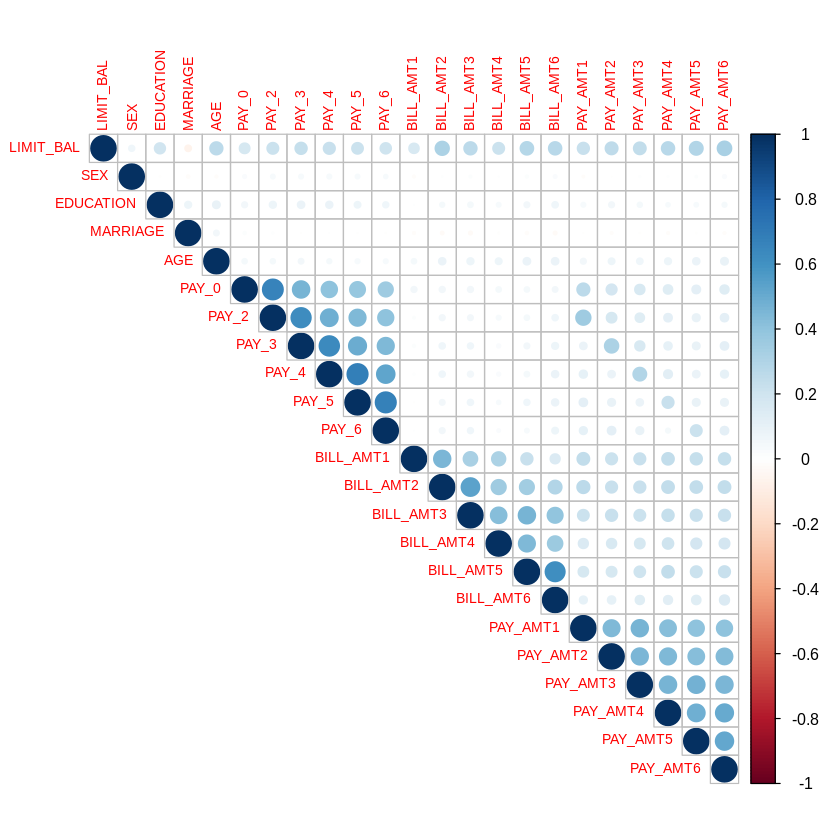

In [11]:
# --- 2. CHECK CORRELAZIONI (Point 3) ---
# Calcoliamo la matrice di correlazione tra le variabili trasformate
# Escludiamo la target per questo calcolo
cor_matrix <- cor(df_transformed[, -1], use = "complete.obs")

# Visualizzazione grafica (opzionale ma utile)
corrplot(cor_matrix, method = "circle", type = "upper", tl.cex = 0.7)

# Funzione per trovare coppie altamente correlate (> 0.6 o < -0.6)
find_high_correlations <- function(cor_mat, threshold=0.60) {
  cor_mat[lower.tri(cor_mat, diag=TRUE)] <- NA
  pairs <- which(abs(cor_mat) > threshold, arr.ind = TRUE)
  if (nrow(pairs) == 0) return(NULL)

  result <- data.frame(
    Var1 = rownames(cor_mat)[pairs[,1]],
    Var2 = colnames(cor_mat)[pairs[,2]],
    Corr = round(cor_mat[pairs], 2)
  )
  return(result[order(-abs(result$Corr)), ])
}

print("--- COPPIE CON ALTA CORRELAZIONE (Candidate per esclusione) ---")
high_corr_pairs <- find_high_correlations(cor_matrix, threshold = 0.60)
print(head(high_corr_pairs, 15))

In [12]:
# --- GESTIONE INTELLIGENTE CORRELAZIONI ---

# Funzione per scegliere quale variabile eliminare basandosi sull'Information Value (IV)
smart_correlation_removal <- function(corr_pairs, results_list) {

  drop_list <- c()

  # Assicuriamoci che le coppie siano ordinate dalla correlazione più alta alla più bassa
  corr_pairs <- corr_pairs[order(-abs(corr_pairs$Corr)), ]

  print("--- INIZIO RISOLUZIONE CONFLITTI (Tengo la variabile con IV più alto) ---")

  for (i in 1:nrow(corr_pairs)) {
    v1 <- corr_pairs$Var1[i]
    v2 <- corr_pairs$Var2[i]

    # Se una delle due è già stata marcata per l'eliminazione in un giro precedente,
    # il conflitto è già risolto. Saltiamo.
    if (v1 %in% drop_list || v2 %in% drop_list) {
      next
    }

    # Recuperiamo l'IV delle due variabili
    # (Gestiamo il caso in cui l'IV non sia presente mettendo 0)
    iv1 <- if(!is.null(results_list[[v1]])) results_list[[v1]]$iv else 0
    iv2 <- if(!is.null(results_list[[v2]])) results_list[[v2]]$iv else 0

    # DECISIONE: Chi ha l'IV più alto vince
    if (iv1 >= iv2) {
      # V1 è più forte (o uguale), eliminiamo V2
      drop_list <- c(drop_list, v2)
      cat(sprintf("Conflitto: %s (IV: %.3f) vs %s (IV: %.3f) -> ELIMINO %s\n", v1, iv1, v2, iv2, v2))
    } else {
      # V2 è più forte, eliminiamo V1
      drop_list <- c(drop_list, v1)
      cat(sprintf("Conflitto: %s (IV: %.3f) vs %s (IV: %.3f) -> ELIMINO %s\n", v1, iv1, v2, iv2, v1))
    }
  }

  return(unique(drop_list))
}

In [13]:
# ESECUZIONE
vars_to_remove_corr <- smart_correlation_removal(high_corr_pairs, final_results)

print("------------------------------------------------")
print("LISTA FINALE VARIABILI DA RIMUOVERE PER CORRELAZIONE:")
print(vars_to_remove_corr)

# --- APPLICAZIONE RIMOZIONE ---
# Ora procediamo con la stepwise selection pulita
# Rimuoviamo le variabili dalla lista dei predittori
predictors_stepwise <- setdiff(names(df_transformed), c("target", vars_to_remove_corr))

[1] "--- INIZIO RISOLUZIONE CONFLITTI (Tengo la variabile con IV più alto) ---"
Conflitto: PAY_4 (IV: 0.363) vs PAY_5 (IV: 0.338) -> ELIMINO PAY_5
Conflitto: PAY_0 (IV: 0.874) vs PAY_2 (IV: 0.547) -> ELIMINO PAY_2
Conflitto: PAY_3 (IV: 0.414) vs PAY_4 (IV: 0.363) -> ELIMINO PAY_4
Conflitto: BILL_AMT5 (IV: 0.016) vs BILL_AMT6 (IV: 0.017) -> ELIMINO BILL_AMT5
[1] "------------------------------------------------"
[1] "LISTA FINALE VARIABILI DA RIMUOVERE PER CORRELAZIONE:"
[1] "PAY_5"     "PAY_2"     "PAY_4"     "BILL_AMT5"


In [14]:
# --- 3. SELEZIONE STEPWISE (Punto 4) ---

# A. Preparazione Variabili
# Prendiamo tutte le variabili del dataset trasformato
all_vars <- names(df_transformed)

# Definiamo i predittori escludendo:
# 1. La target variable
# 2. Le variabili che abbiamo deciso di rimuovere per alta correlazione
predictors <- setdiff(all_vars, c("target", vars_to_remove_corr))

# B. Costruzione Formula
# Creiamo la stringa "target ~ var1 + var2 + ..."
formula_str <- paste("target ~", paste(predictors, collapse = " + "))

print(paste("Numero variabili in input al modello:", length(predictors)))

# C. Modello Full e Stepwise
print("--- INIZIO SELEZIONE STEPWISE (AIC) ---")

# Gestione NA: La regressione logistica non accetta valori mancanti.
# Creiamo un dataset temporaneo pulito solo con le colonne che ci servono
df_model_final <- na.omit(df_transformed[, c("target", predictors)])

# 1. Modello Completo (con tutte le variabili non correlate)
full_model <- glm(as.formula(formula_str), data = df_model_final, family = "binomial")

# 2. Stepwise Selection (Backward/Forward)
# Trace=0 nasconde i calcoli intermedi, trace=1 li mostra
final_model <- step(full_model, direction = "both", trace = 0)

[1] "Numero variabili in input al modello: 19"
[1] "--- INIZIO SELEZIONE STEPWISE (AIC) ---"


In [15]:
# --- 4. RISULTATI FINALI E SIGNIFICATIVITÀ ---

print("----------------------------------------------------")
print("VARIABILI SELEZIONATE (SIGNIFICATIVE)")
print("----------------------------------------------------")
# Mostriamo i coefficienti del modello vincitore
print(summary(final_model))

# Estraiamo i nomi delle variabili rimaste
coef_table <- summary(final_model)$coefficients
# Rimuoviamo l'intercetta dalla lista
significant_vars <- rownames(coef_table)[rownames(coef_table) != "(Intercept)"]

print("Lista finale dei fattori per il modello:")
print(significant_vars)

[1] "----------------------------------------------------"
[1] "VARIABILI SELEZIONATE (SIGNIFICATIVE)"
[1] "----------------------------------------------------"

Call:
glm(formula = target ~ LIMIT_BAL + SEX + EDUCATION + MARRIAGE + 
    AGE + PAY_0 + PAY_3 + PAY_6 + BILL_AMT1 + BILL_AMT2 + BILL_AMT3 + 
    BILL_AMT4 + PAY_AMT1 + PAY_AMT2 + PAY_AMT3 + PAY_AMT4, family = "binomial", 
    data = df_model_final)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.25145    0.01583 -79.050  < 2e-16 ***
LIMIT_BAL   -0.41511    0.04338  -9.570  < 2e-16 ***
SEX         -0.75226    0.16375  -4.594 4.35e-06 ***
EDUCATION   -0.38390    0.08428  -4.555 5.24e-06 ***
MARRIAGE    -1.12461    0.18913  -5.946 2.75e-09 ***
AGE         -0.32364    0.11000  -2.942 0.003259 ** 
PAY_0       -0.76853    0.01787 -43.011  < 2e-16 ***
PAY_3       -0.26484    0.02904  -9.121  < 2e-16 ***
PAY_6       -0.37231    0.03197 -11.647  < 2e-16 ***
BILL_AMT1   -0.31301    0.15009  -2.085 0.

In [16]:
# --- 5. CHECK MONOTONICITÀ (Punto 2) ---
# Verifichiamo se le variabili "sopravvissute" hanno un andamento logico

check_monotonicity <- function(var_name, results_list) {
  # Recuperiamo la tabella WOE calcolata all'inizio
  woe_tab <- results_list[[var_name]]$woe_table
  if (is.null(woe_tab)) return(NA)

  woes <- woe_tab$WOE
  # Controlla se sempre crescente O sempre decrescente
  is_monotonic <- all(diff(woes) >= 0) || all(diff(woes) <= 0)
  return(is_monotonic)
}

print("--- CHECK MONOTONICITÀ SULLE SELEZIONATE ---")

for (v in significant_vars) {
  # Pulizia nome: 'step' a volte aggiunge backticks (`) ai nomi, li togliamo
  clean_v <- gsub("`", "", v)

  if (clean_v %in% names(final_results)) {
    is_mono <- check_monotonicity(clean_v, final_results)
    status <- ifelse(is_mono, "MONOTONA (OK)", "NON MONOTONA (Check U-Shape)")

    # Recuperiamo anche l'IV per avere un quadro completo
    iv_val <- final_results[[clean_v]]$iv

    cat(sprintf("%-15s | IV: %.4f | %s\n", clean_v, iv_val, status))
  } else {
    cat(clean_v, ": Dati non trovati in final_results\n")
  }
}

[1] "--- CHECK MONOTONICITÀ SULLE SELEZIONATE ---"
LIMIT_BAL       | IV: 0.1750 | MONOTONA (OK)
SEX             | IV: 0.0092 | MONOTONA (OK)
EDUCATION       | IV: 0.0373 | NON MONOTONA (Check U-Shape)
MARRIAGE        | IV: 0.0072 | NON MONOTONA (Check U-Shape)
AGE             | IV: 0.0215 | NON MONOTONA (Check U-Shape)
PAY_0           | IV: 0.8736 | NON MONOTONA (Check U-Shape)
PAY_3           | IV: 0.4141 | NON MONOTONA (Check U-Shape)
PAY_6           | IV: 0.2918 | NON MONOTONA (Check U-Shape)
BILL_AMT1       | IV: 0.0143 | NON MONOTONA (Check U-Shape)
BILL_AMT2       | IV: 0.0107 | NON MONOTONA (Check U-Shape)
BILL_AMT3       | IV: 0.0108 | NON MONOTONA (Check U-Shape)
BILL_AMT4       | IV: 0.0149 | NON MONOTONA (Check U-Shape)
PAY_AMT1        | IV: 0.1678 | MONOTONA (OK)
PAY_AMT2        | IV: 0.1586 | MONOTONA (OK)
PAY_AMT3        | IV: 0.1290 | MONOTONA (OK)
PAY_AMT4        | IV: 0.0985 | MONOTONA (OK)


In [17]:

#6 Facciamo un check sulle variabili che non sono monotone

if (!require("ggplot2")) install.packages("ggplot2")
library(ggplot2)

# --- FUNZIONE PER PLOTTARE IL WOE ---
plot_woe_trend <- function(var_name, results_list) {

  # Recupera la tabella WOE
  woe_data <- results_list[[var_name]]$woe_table

  if (is.null(woe_data)) {
    cat("Dati non trovati per:", var_name, "\n")
    return(NULL)
  }

  # Assicuriamoci che i bin siano ordinati come fattori
  woe_data$bin <- factor(woe_data$bin, levels = woe_data$bin)

  # Information Value della variabile (per il titolo)
  iv_val <- results_list[[var_name]]$iv

  # Creazione Grafico
  p <- ggplot(woe_data, aes(x = bin, y = WOE, group = 1)) +
    # Linea e Punti del WOE
    geom_line(color = "darkblue", size = 1) +
    geom_point(color = "darkblue", size = 3) +
    # Linea dello zero (Neutralità)
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
    # Etichette e Titoli
    labs(
      title = paste("WOE Trend:", var_name),
      subtitle = paste("Information Value (IV):", round(iv_val, 4)),
      x = "Bins (Gruppi)",
      y = "Weight of Evidence (WOE)"
    ) +
    # Tema grafico pulito (stile report)
    theme_minimal() +
    theme(
      axis.text.x = element_text(angle = 45, hjust = 1), # Ruota etichette asse X
      plot.title = element_text(face = "bold")
    )

  print(p)
}

Loading required package: ggplot2



[1] "--- GENERAZIONE GRAFICI WOE ---"


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


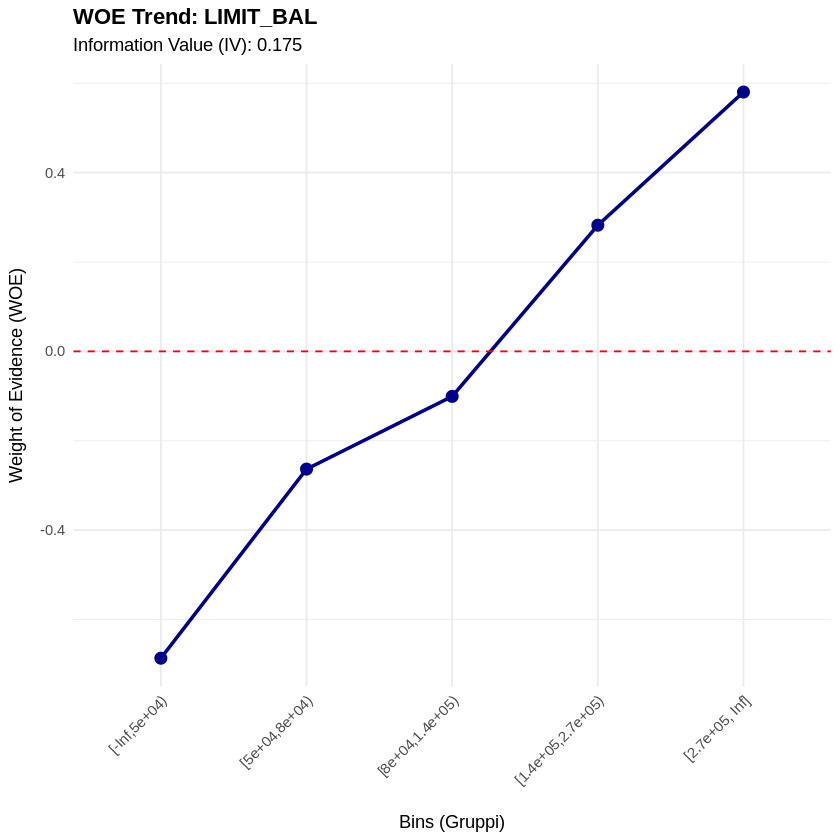

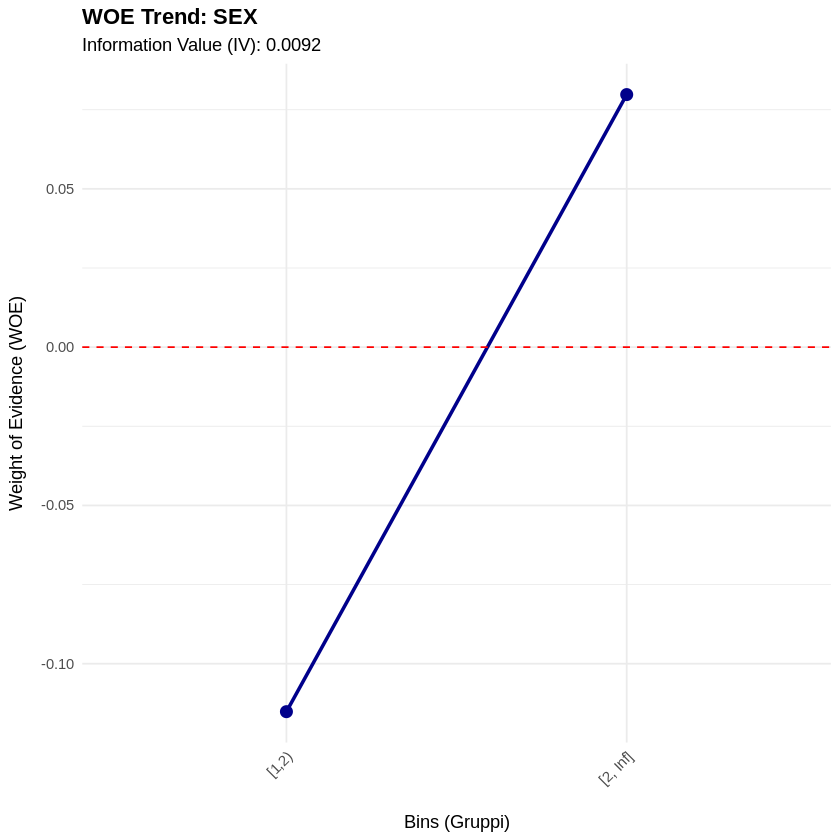

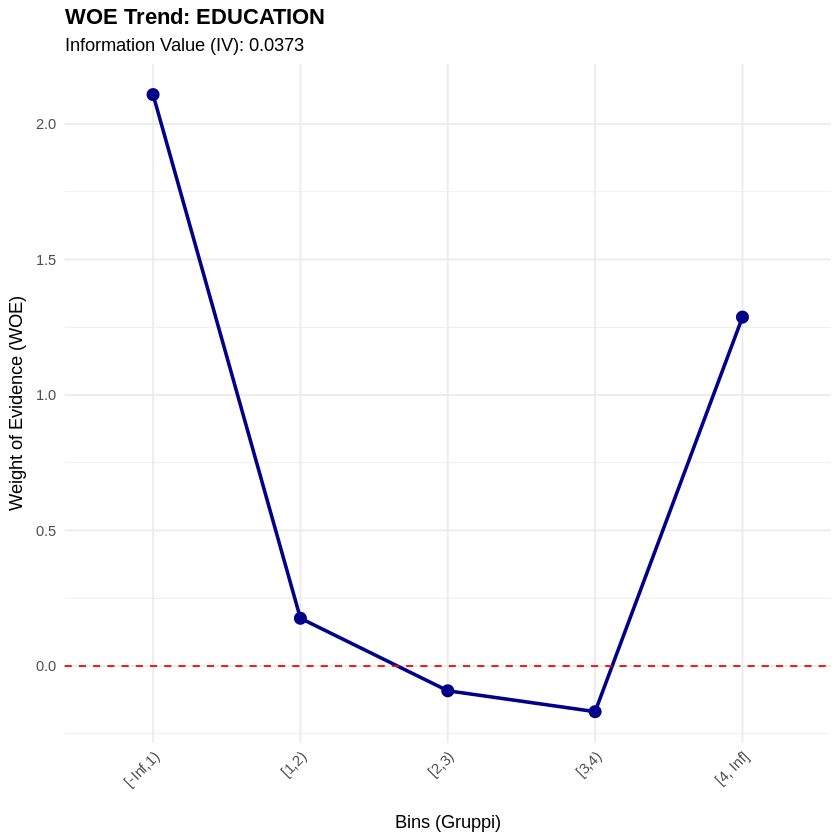

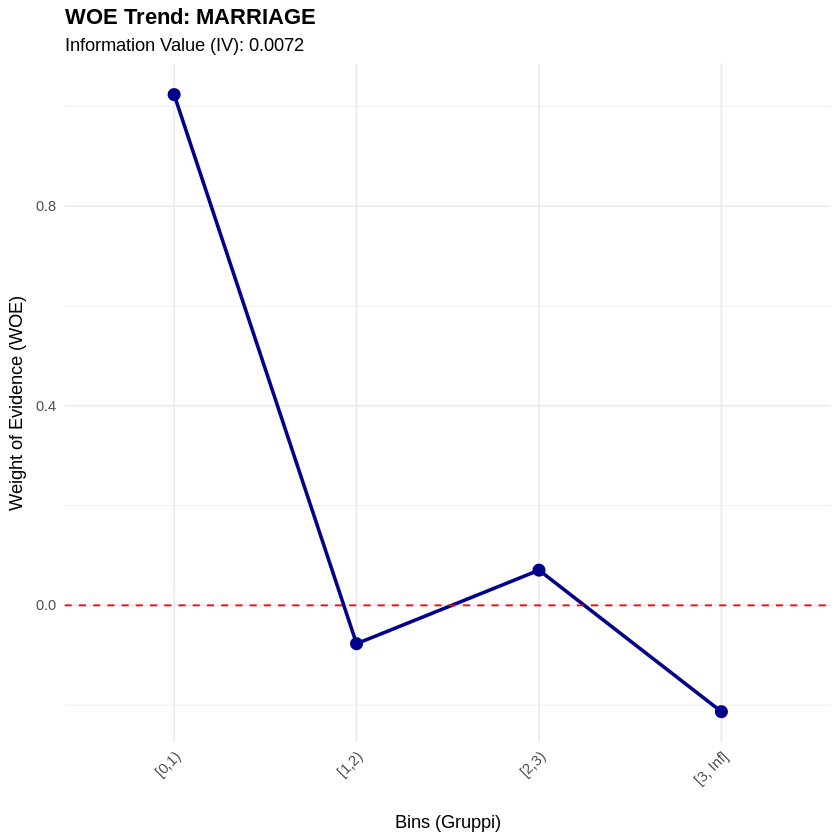

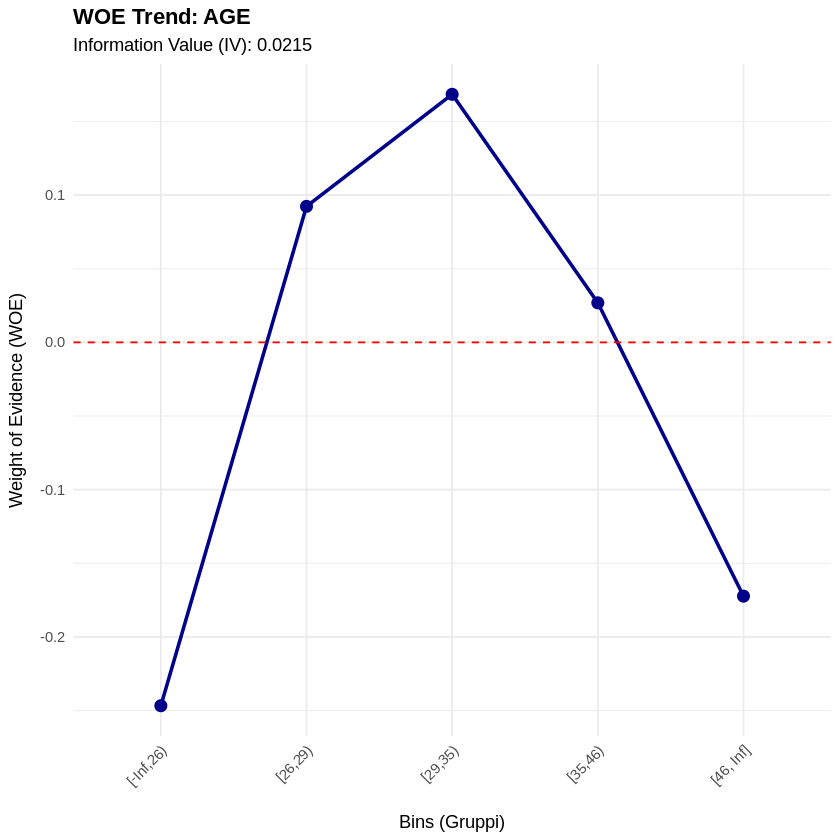

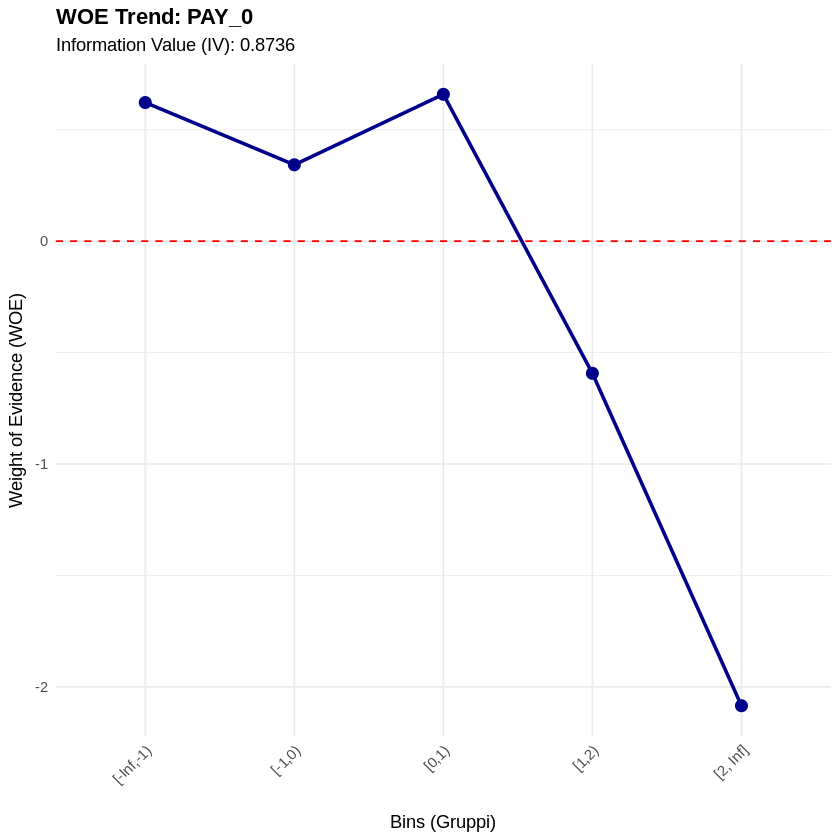

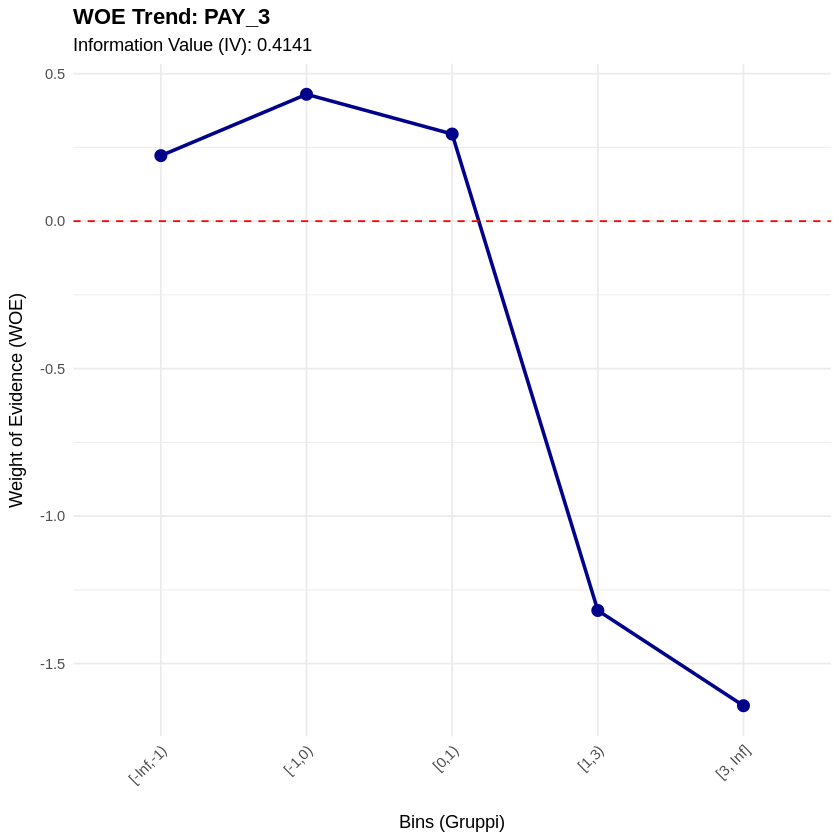

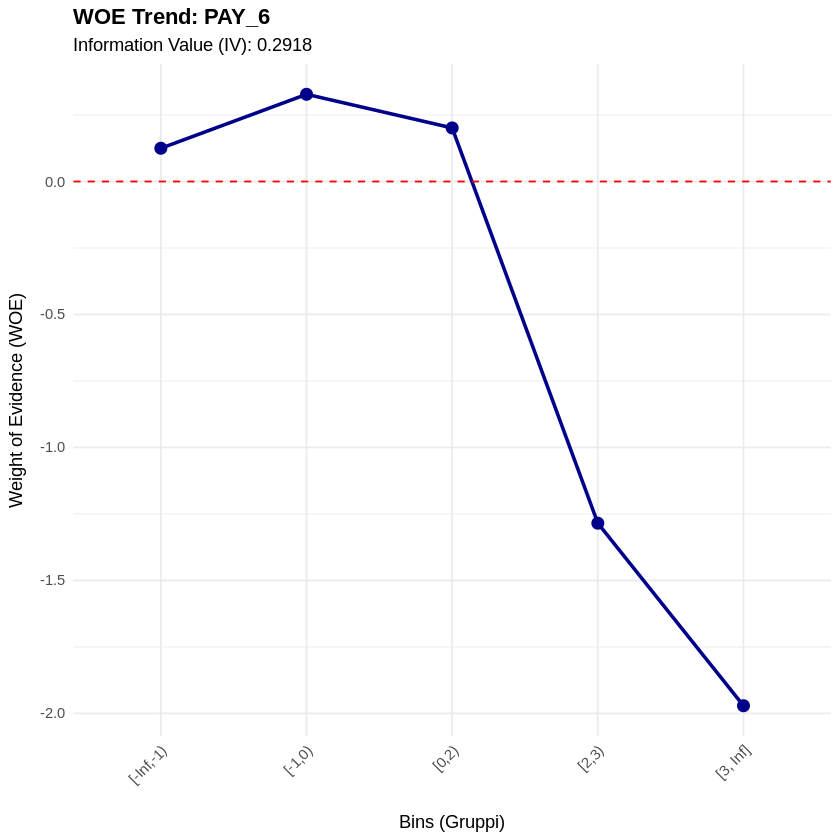

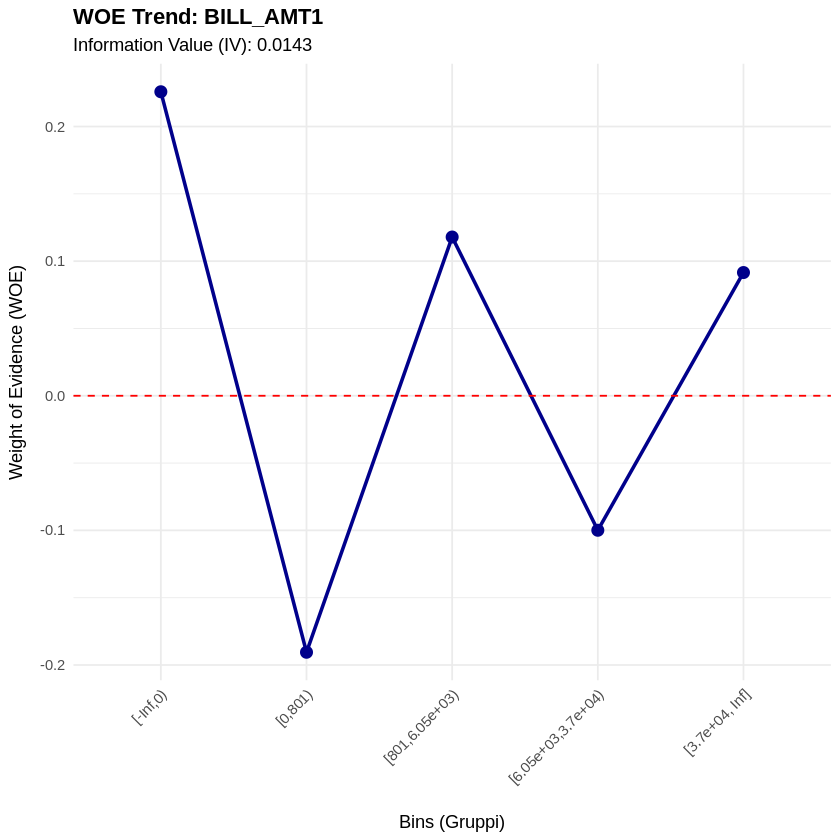

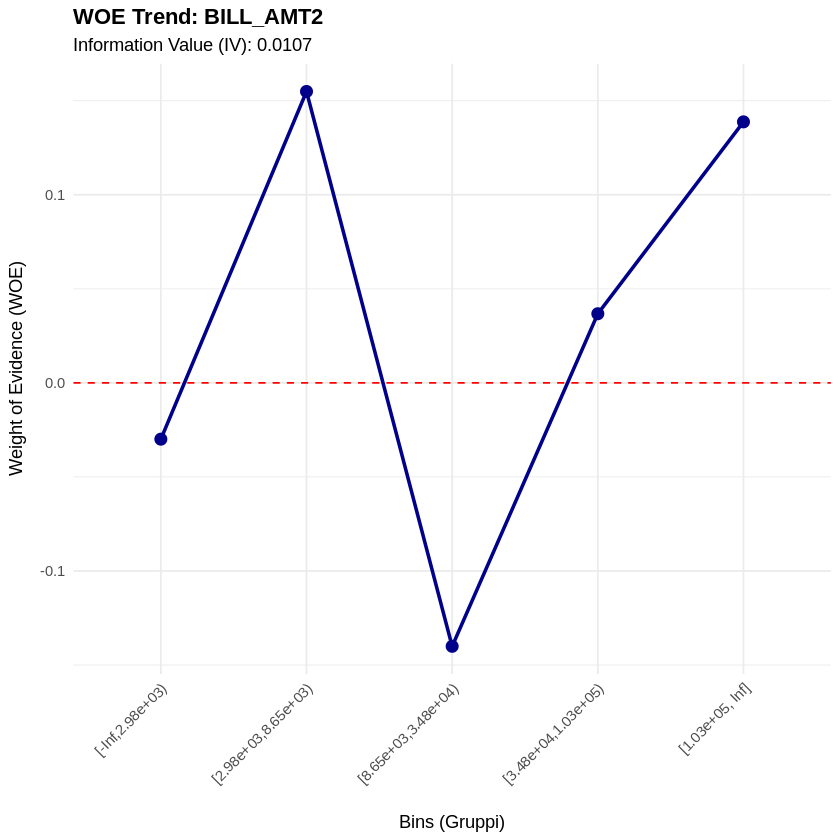

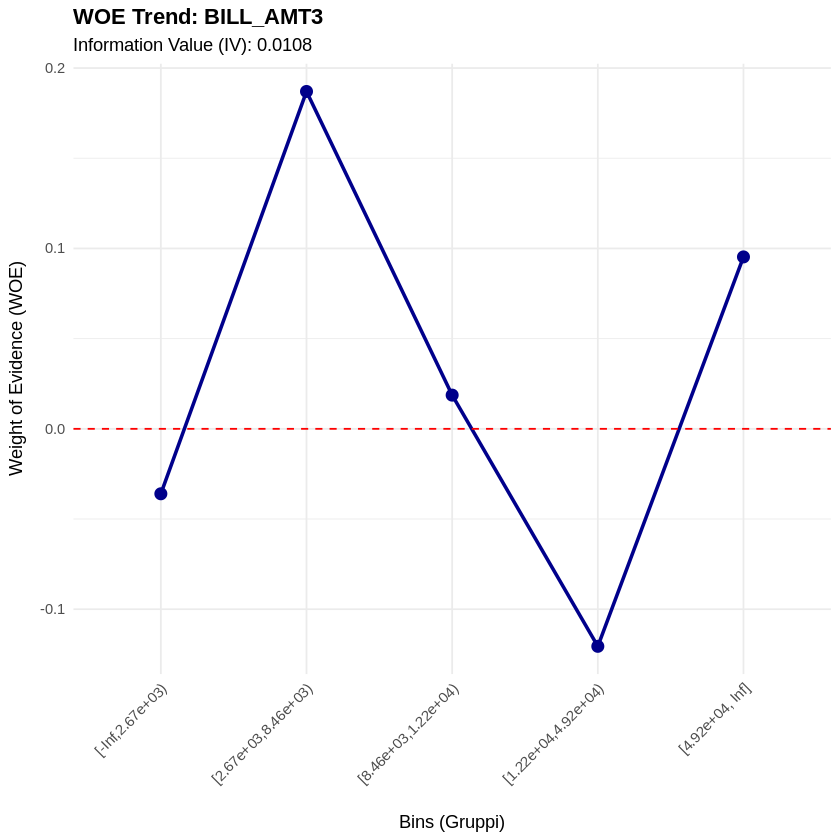

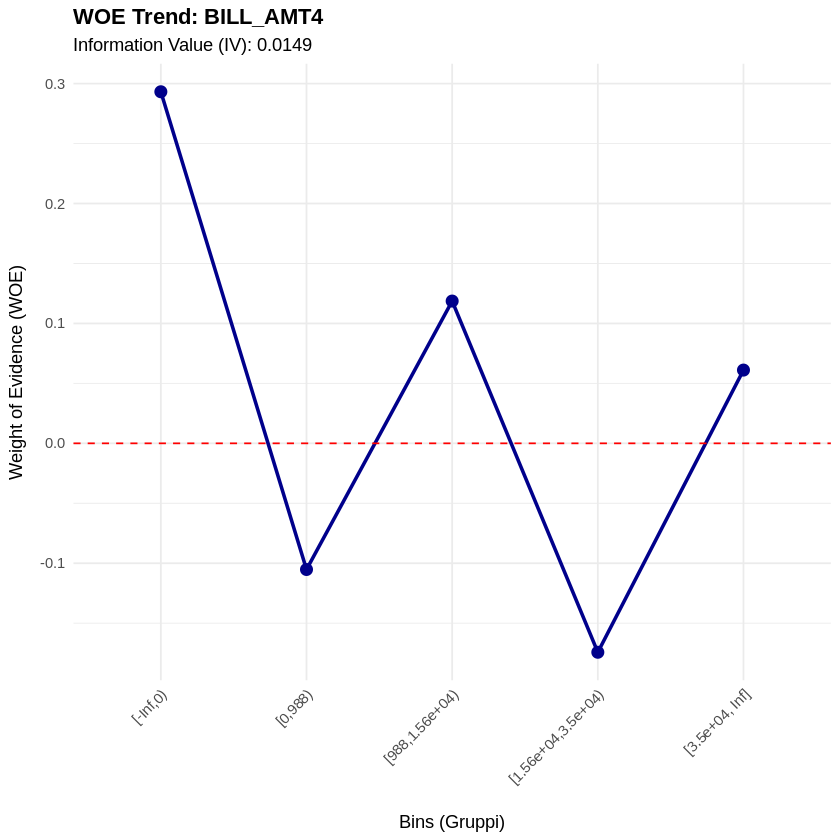

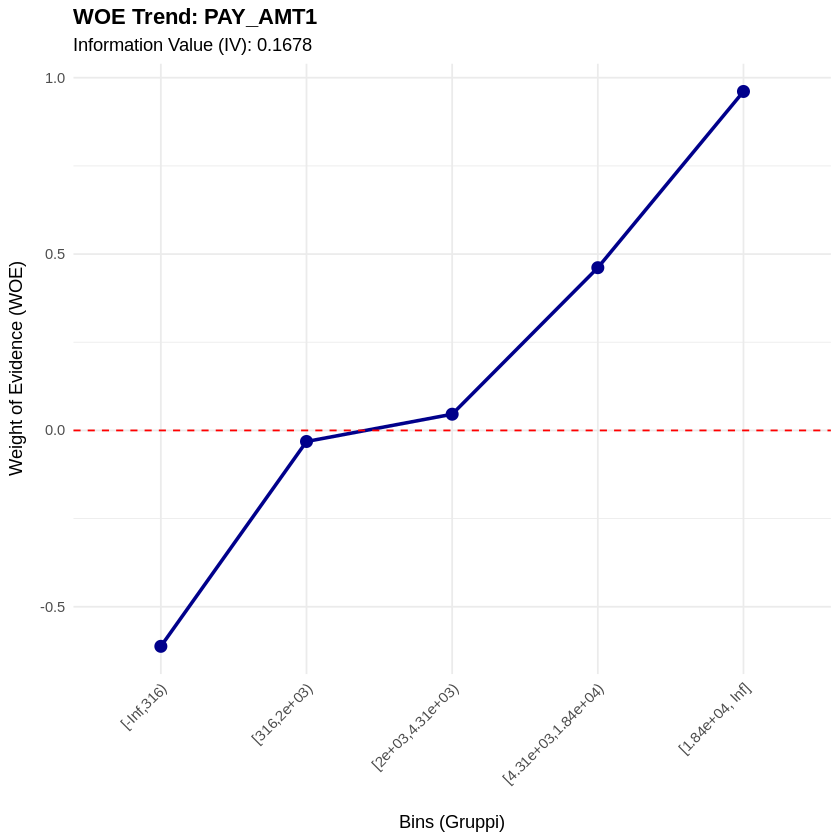

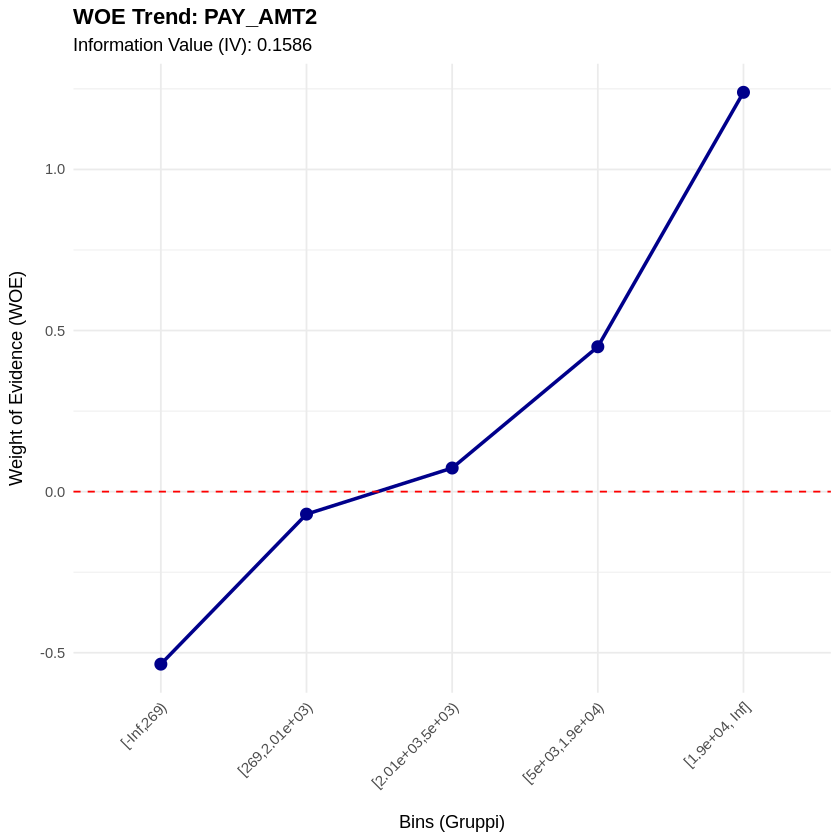

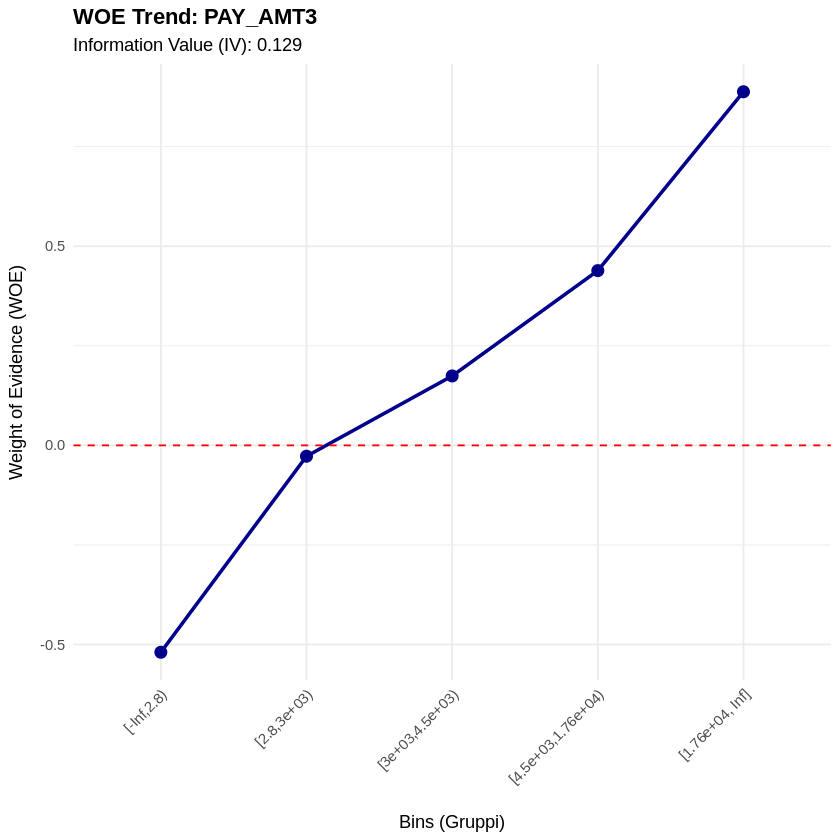

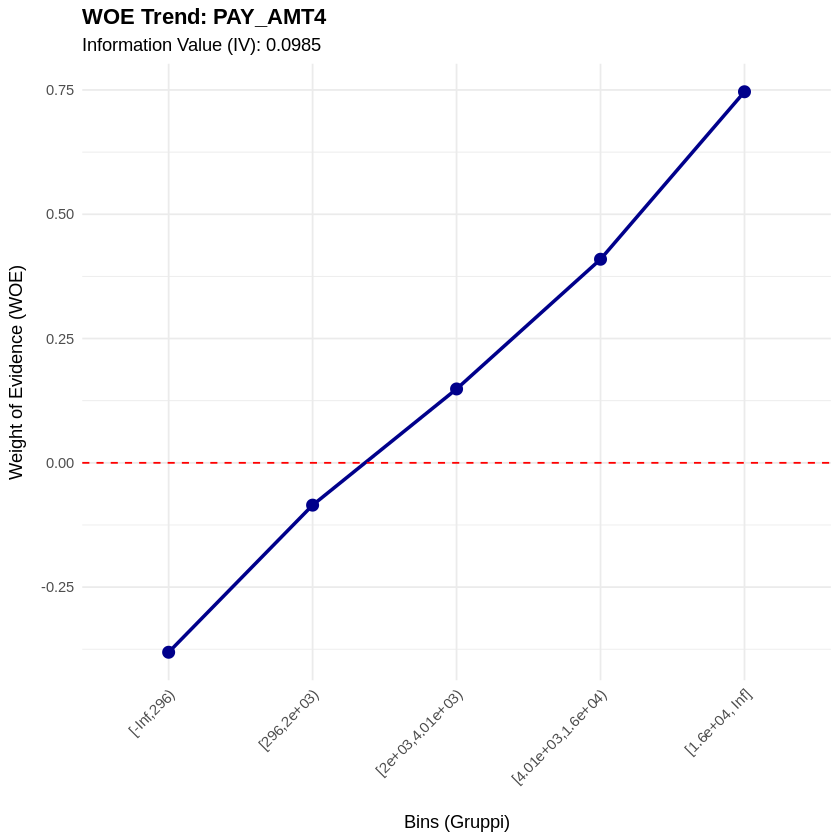

In [18]:
# --- ESECUZIONE SUI FATTORI DEL MODELLO ---

# Usiamo la lista 'significant_vars' che è uscita dalla Stepwise selection
# Se non hai più la lista in memoria, puoi crearla a mano con i nomi che mi hai incollato:
# significant_vars <- c("PAY_0", "PAY_3", "PAY_6", "LIMIT_BAL", "EDUCATION", "AGE", "PAY_AMT1")

print("--- GENERAZIONE GRAFICI WOE ---")

for (var in significant_vars) {
  # Pulisci il nome da eventuali caratteri strani
  clean_v <- gsub("`", "", var)

  # Genera il grafico solo se abbiamo i dati
  if (clean_v %in% names(final_results)) {
    plot_woe_trend(clean_v, final_results)

    # Pausa opzionale per vedere i grafici uno alla volta (se usi RStudio non serve)
    # Sys.sleep(1)
  }
}

In [19]:
# --- APPLICAZIONE CORREZIONI MANUALI ---

# Funzione helper (se non l'hai già caricata)
apply_manual_breaks <- function(df, var_name, target_var, new_breaks) {
  x <- df[[var_name]]
  bins <- cut(x, breaks = new_breaks, include.lowest = TRUE, right = FALSE)
  res <- calculate_woe_iv(bins, df[[target_var]])
  # Aggiorna la lista globale
  final_results[[var_name]] <<- list(
    breaks = new_breaks,
    woe_table = res$table,
    iv = res$iv_total
  )
  print(paste("--> Corretto:", var_name, "| Nuovo IV:", round(res$iv_total, 4)))
}

print("--- INIZIO CORREZIONI MANUALI ---")

# 1. EDUCATION: Uniamo i gruppi piccoli 1 e 2
apply_manual_breaks(df, "EDUCATION", target_var, c(-Inf, 2, 3, 4, Inf))

# 2. MARRIAGE: Uniamo 1 e 2
apply_manual_breaks(df, "MARRIAGE", target_var, c(-Inf, 2, 3, Inf))

# 3. AGE: MANTENIAMO COSÌ (U-Shape giustificata)
print("--> AGE: Nessuna modifica (U-Shape accettata)")

# 4. PAY_0: Uniamo i "buoni" (-Inf fino a 1)
apply_manual_breaks(df, "PAY_0", target_var, c(-Inf, 1, 2, Inf))

# 5. PAY_3: Uniamo i "buoni"
apply_manual_breaks(df, "PAY_3", target_var, c(-Inf, 1, 3, Inf))

# 6. PAY_6: Uniamo i "buoni" (fino a 2 perché il taglio automatico era lì)
apply_manual_breaks(df, "PAY_6", target_var, c(-Inf, 2, 3, Inf))

# 7. BILL_AMT: Se vuoi tenerle, proviamo a semplificare drasticamente BILL_AMT1
# Creiamo solo 3 gruppi: Saldo negativo/zero, Medio, Alto
# Usiamo terzili approssimativi o zero come ancora
apply_manual_breaks(df, "BILL_AMT1", target_var, c(-Inf, 0, 50000, Inf))

print("--- CORREZIONI COMPLETATE ---")

[1] "--- INIZIO CORREZIONI MANUALI ---"
[1] "--> Corretto: EDUCATION | Nuovo IV: 0.0363"
[1] "--> Corretto: MARRIAGE | Nuovo IV: 0.0056"
[1] "--> AGE: Nessuna modifica (U-Shape accettata)"
[1] "--> Corretto: PAY_0 | Nuovo IV: 0.861"
[1] "--> Corretto: PAY_3 | Nuovo IV: 0.4105"
[1] "--> Corretto: PAY_6 | Nuovo IV: 0.2882"
[1] "--> Corretto: BILL_AMT1 | Nuovo IV: 0.0069"
[1] "--- CORREZIONI COMPLETATE ---"


In [20]:
library(ggplot2)
library(data.table)

# --- 1. DEFINIZIONE FUNZIONI NECESSARIE ---

# Funzione per applicare i tagli manuali e aggiornare i risultati
apply_manual_breaks <- function(df, var_name, target_var, new_breaks) {
  # Calcola i nuovi bin
  x <- df[[var_name]]
  bins <- cut(x, breaks = new_breaks, include.lowest = TRUE, right = FALSE)

  # Ricalcola WOE e IV
  res <- calculate_woe_iv(bins, df[[target_var]])

  # Aggiorna la lista globale dei risultati
  final_results[[var_name]] <<- list(
    breaks = new_breaks,
    woe_table = res$table,
    iv = res$iv_total
  )
  return(res$table)
}

# Funzione per generare il grafico
plot_woe_trend <- function(var_name, results_list) {
  woe_data <- results_list[[var_name]]$woe_table
  iv_val <- results_list[[var_name]]$iv

  # Ordina i bin per il grafico
  woe_data$bin <- factor(woe_data$bin, levels = woe_data$bin)

  p <- ggplot(woe_data, aes(x = bin, y = WOE, group = 1)) +
    geom_line(color = "#0073C2", size = 1.2) +      # Linea Blu
    geom_point(color = "#0073C2", size = 4) +       # Punti Blu
    geom_hline(yintercept = 0, linetype = "dashed", color = "darkred") +
    labs(
      title = paste("Corrected WOE Trend:", var_name),
      subtitle = paste("New IV:", round(iv_val, 4), "- Monotonicity Check"),
      x = "Final Bins", y = "WOE"
    ) +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

  print(p)
}

[1] "--- APPLICAZIONE AGGIUSTAMENTI E VISUALIZZAZIONE ---"
[1] ">>> 1. PAY_0 (Corrected)"
        bin     N    Gi    Bi        WOE IV_partial
     <fctr> <int> <int> <int>      <num>      <num>
1: [-Inf,1) 23182 19975  3207  0.5704586 0.21202503
2:    [1,2)  3688  2436  1252 -0.5930719 0.05005818
3: [2, Inf]  3130   953  2177 -2.0847752 0.59889299
[1] ">>> 2. PAY_3 (Corrected)"
        bin     N    Gi    Bi        WOE IV_partial
     <fctr> <int> <int> <int>      <num>      <num>
1: [-Inf,1) 25787 21353  4434  0.3132031 0.07697086
2:    [1,3)  3823  1853  1970 -1.3199146 0.28715472
3: [3, Inf]   390   158   232 -1.6428293 0.04632496


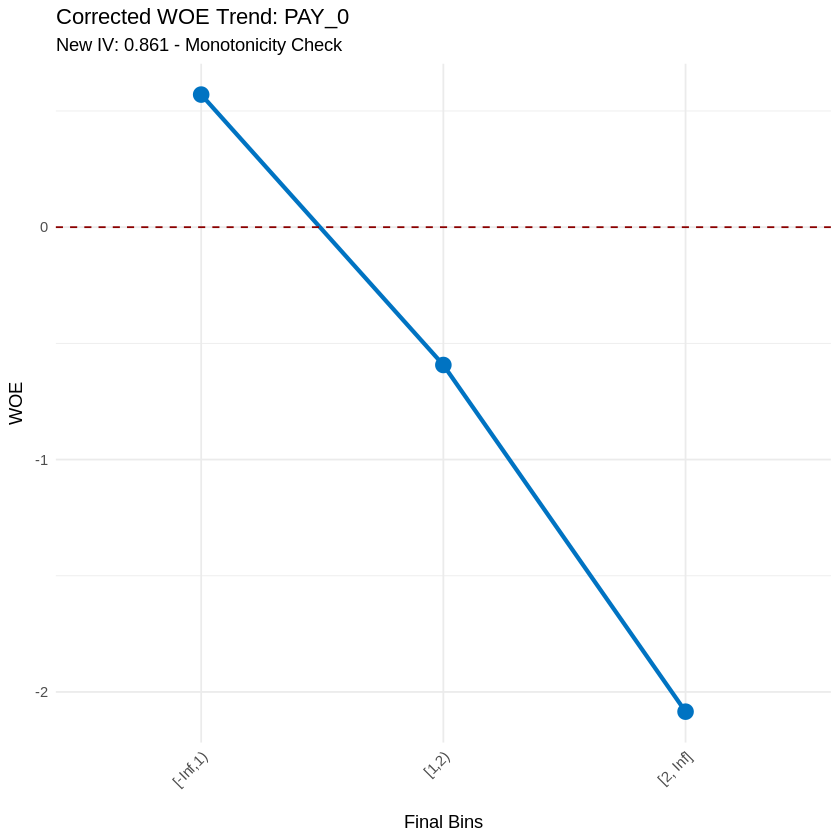

[1] ">>> 3. PAY_6 (Corrected)"
        bin     N    Gi    Bi        WOE IV_partial
     <fctr> <int> <int> <int>      <num>      <num>
1: [-Inf,2) 26921 21896  5025  0.2131915 0.03836062
2:    [2,3)  2766  1365  1401 -1.2847188 0.19617392
3: [3, Inf]   313   103   210 -1.9710655 0.05368607


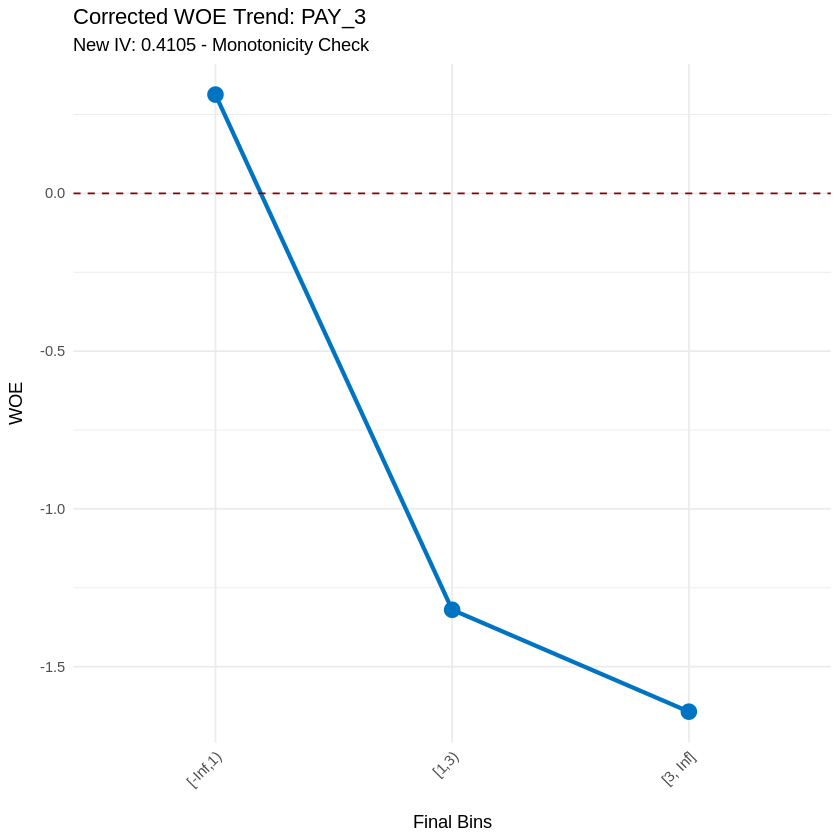

[1] ">>> 4. EDUCATION (Corrected)"
        bin     N    Gi    Bi         WOE  IV_partial
     <fctr> <int> <int> <int>       <num>       <num>
1: [-Inf,2) 10599  8563  2036  0.17777649 0.010611957
2:    [2,3) 14030 10700  3330 -0.09141557 0.004007548
3:    [3,4)  4917  3680  1237 -0.16846335 0.004868624
4: [4, Inf]   454   421    33  1.28743827 0.016796305


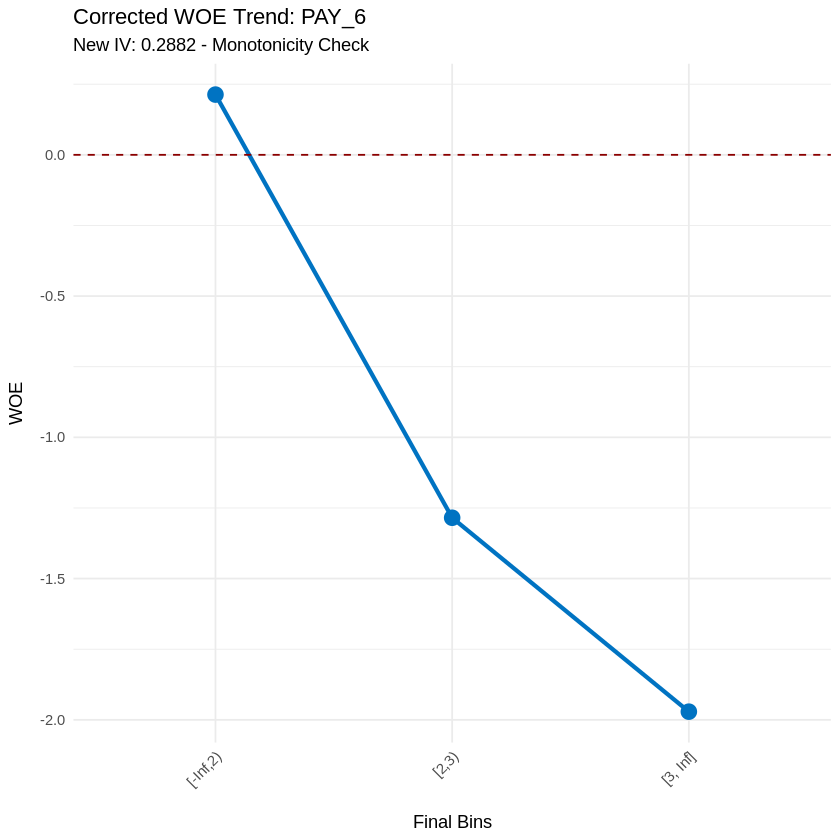

[1] ">>> 5. MARRIAGE (Corrected)"
        bin     N    Gi    Bi         WOE   IV_partial
     <fctr> <int> <int> <int>       <num>        <num>
1: [-Inf,2) 13713 10502  3211 -0.07370370 0.0025339981
2:    [2,3) 15964 12623  3341  0.07056338 0.0025974164
3: [3, Inf]   323   239    84 -0.21304025 0.0005174354


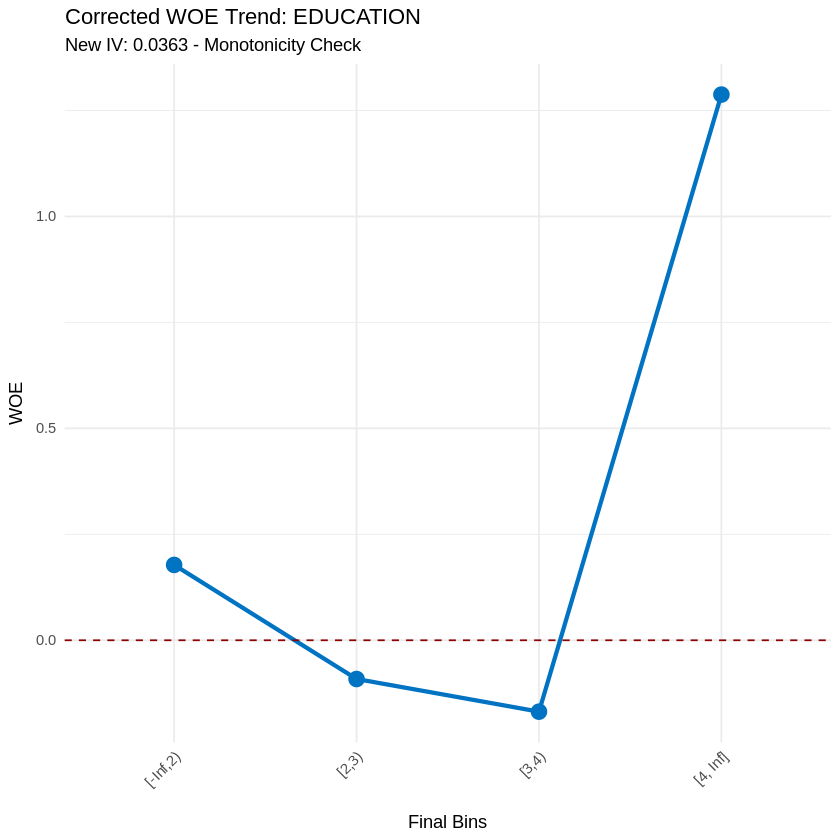

[1] ">>> 6. BILL_AMT1 (Corrected)"
            bin     N    Gi    Bi         WOE  IV_partial
         <fctr> <int> <int> <int>       <num>       <num>
1:     [-Inf,0)   590   481   109  0.22583238 0.000939840
2:    [0,5e+04) 19903 15302  4601 -0.05697714 0.002187930
3: [5e+04, Inf]  9507  7581  1926  0.11151280 0.003818027


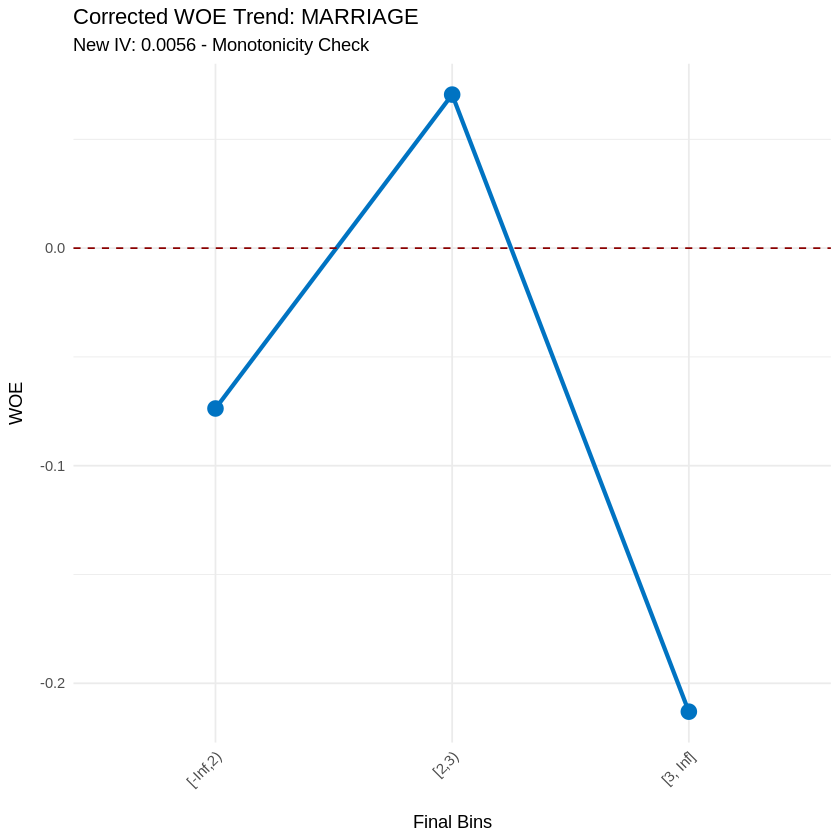

[1] ">>> 7. AGE (Original U-Shape)"
         bin     N    Gi    Bi         WOE   IV_partial
      <fctr> <int> <int> <int>       <num>        <num>
1: [-Inf,26)  3871  2839  1032 -0.24673379 0.0083898479
2:   [26,29)  4142  3290   852  0.09236931 0.0011476270
3:   [29,35)  7683  6196  1487  0.16845625 0.0069258336
4:   [35,46)  9635  7548  2087  0.02686800 0.0002301092
5: [46, Inf]  4669  3491  1178 -0.17231686 0.0048418743


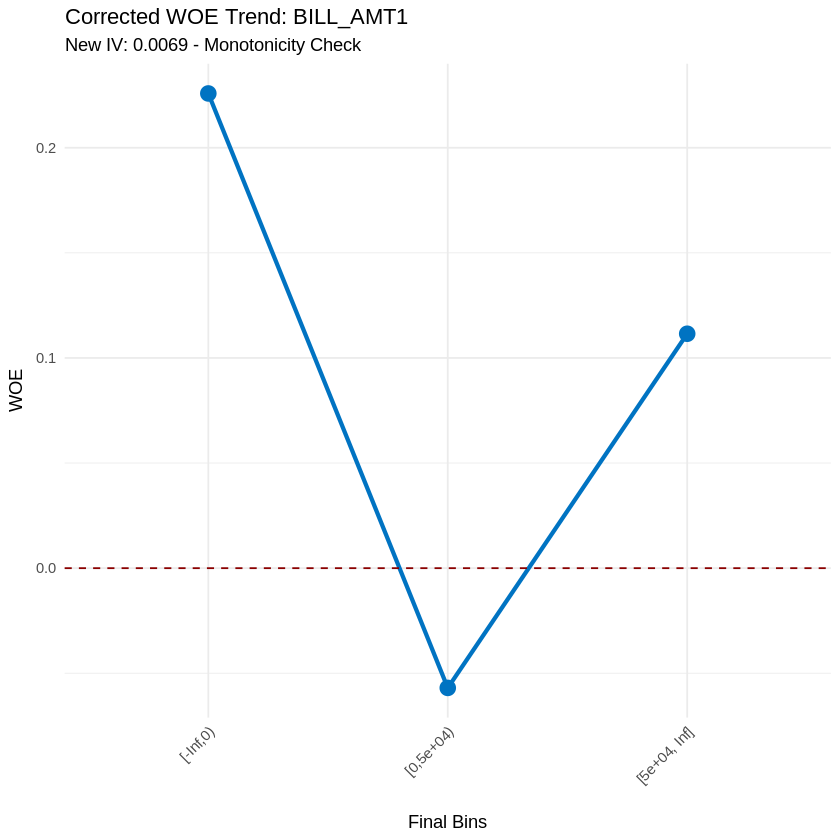

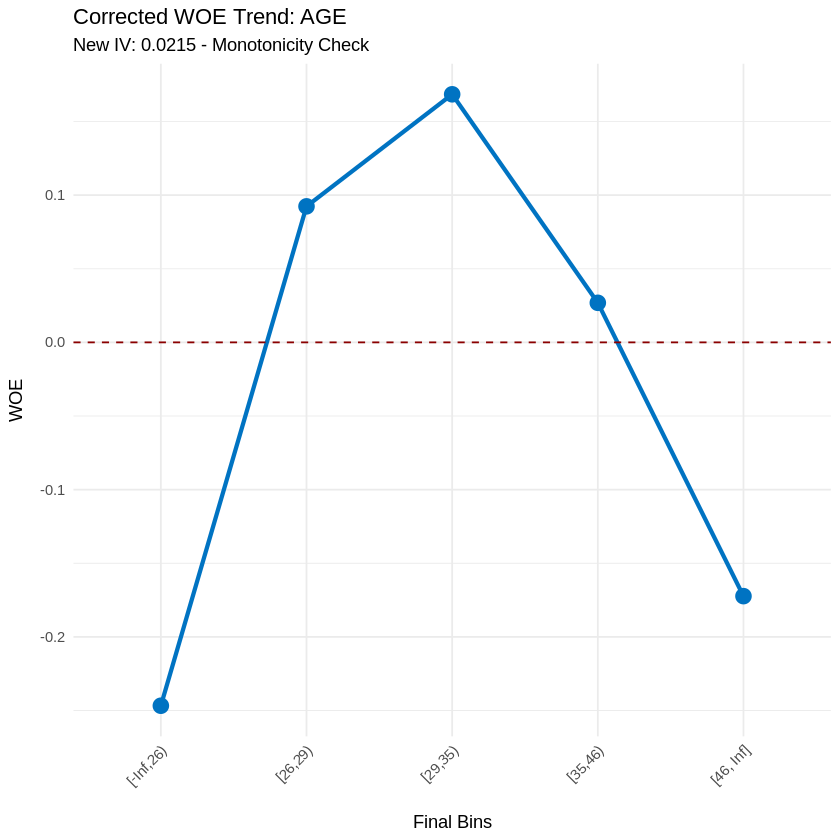

In [21]:
# --- 2. APPLICAZIONE DELLE CORREZIONI (E Stampa Tabelle) ---

print("--- APPLICAZIONE AGGIUSTAMENTI E VISUALIZZAZIONE ---")

# Lista delle variabili da correggere e visualizzare
vars_to_fix <- c("PAY_0", "PAY_3", "PAY_6", "EDUCATION", "MARRIAGE", "BILL_AMT1", "AGE")

# A. PAY_0: Uniamo i "buoni" (-2, -1, 0) in un unico gruppo
print(">>> 1. PAY_0 (Corrected)")
tab_pay0 <- apply_manual_breaks(df, "PAY_0", target_var, c(-Inf, 1, 2, Inf))
print(tab_pay0)
plot_woe_trend("PAY_0", final_results)

# B. PAY_3: Uniamo i "buoni"
print(">>> 2. PAY_3 (Corrected)")
tab_pay3 <- apply_manual_breaks(df, "PAY_3", target_var, c(-Inf, 1, 3, Inf))
print(tab_pay3)
plot_woe_trend("PAY_3", final_results)

# C. PAY_6: Uniamo i "buoni"
print(">>> 3. PAY_6 (Corrected)")
tab_pay6 <- apply_manual_breaks(df, "PAY_6", target_var, c(-Inf, 2, 3, Inf))
print(tab_pay6)
plot_woe_trend("PAY_6", final_results)

# D. EDUCATION: Uniamo i gruppi piccoli (1 e 2)
print(">>> 4. EDUCATION (Corrected)")
# Assumiamo che i valori siano 1,2,3,4,5,6. Uniamo fino a 2.
tab_edu <- apply_manual_breaks(df, "EDUCATION", target_var, c(-Inf, 2, 3, 4, Inf))
print(tab_edu)
plot_woe_trend("EDUCATION", final_results)

# E. MARRIAGE: Uniamo i gruppi piccoli (0 e 1)
print(">>> 5. MARRIAGE (Corrected)")
tab_marr <- apply_manual_breaks(df, "MARRIAGE", target_var, c(-Inf, 2, 3, Inf))
print(tab_marr)
plot_woe_trend("MARRIAGE", final_results)

# F. BILL_AMT1: Semplificazione drastica (Basso vs Alto saldo)
print(">>> 6. BILL_AMT1 (Corrected)")
tab_bill <- apply_manual_breaks(df, "BILL_AMT1", target_var, c(-Inf, 0, 50000, Inf))
print(tab_bill)
plot_woe_trend("BILL_AMT1", final_results)

# G. AGE: Nessuna modifica, ma visualizziamo per conferma U-Shape
print(">>> 7. AGE (Original U-Shape)")
print(final_results[["AGE"]]$woe_table)
plot_woe_trend("AGE", final_results)

In [22]:
###########################################################################

#LOGIT model estimation --- FASE 3.8: STIMA DEL MODELLO LOGIT E CALCOLO SCORE ---

# 1. TRASFORMAZIONE DATASET (WOE)
# Ricostruiamo il dataset finale usando i WOE
#corretti che abbiamo salvato in 'final_results'

create_woe_dataset <- function(df, results_list, target_var) {
  df_final <- data.frame(target = df[[target_var]])

  # Identifichiamo le variabili comuni tra il dataset e i nostri risultati
  vars_to_use <- intersect(names(df), names(results_list))

  for (var in vars_to_use) {
    # Recuperiamo i parametri (Breaks e Tabella WOE)
    breaks <- results_list[[var]]$breaks
    woe_table <- results_list[[var]]$woe_table

    # Binning
    x <- df[[var]]
    bins <- cut(x, breaks = breaks, include.lowest = TRUE, right = FALSE)

    # Mapping WOE
    # Usiamo as.character per assicurarci che il match funzioni
    woe_map <- setNames(woe_table$WOE, as.character(woe_table$bin))
    df_final[[paste0(var, "_WOE")]] <- woe_map[as.character(bins)]
  }
  return(df_final)
}

print("Generazione dataset per il modello (WOE transformation)...")
df_model <- create_woe_dataset(df, final_results, target_var)
df_model <- na.omit(df_model) # Pulizia finale per sicurezza

# 2. STIMA DEL MODELLO (LOGISTIC REGRESSION)
print("--- STIMA DEL MODELLO LOGISTICO ---")
# Usiamo tutte le colonne WOE create per predire la target
final_logistic_model <- glm(target ~ ., data = df_model, family = "binomial")

# Estrazione dei Coefficienti (Tabella 3 del PDF)
model_summary <- summary(final_logistic_model)
coefficients_table <- model_summary$coefficients

# Aggiungiamo colonne per renderla leggibile come nel PDF
results_table <- data.frame(
  Variable = rownames(coefficients_table),
  Estimate = round(coefficients_table[, "Estimate"], 4),
  Std_Error = round(coefficients_table[, "Std. Error"], 4),
  z_value = round(coefficients_table[, "z value"], 2),
  P_Value = round(coefficients_table[, "Pr(>|z|)"], 4)
)

print("RISULTATI STIMA MODELLO (Coefficienti):")
print(results_table)

# 3. CALCOLO DELLA PROBABILITÀ DI DEFAULT (PD)
# Applichiamo il modello a ogni cliente per ottenere la PD stimata
df_model$Estimated_PD <- predict(final_logistic_model, type = "response")

# Visualizziamo le prime PD calcolate
print("Esempio di PD calcolate (Prime 10 righe):")
print(head(df_model[, c("target", "Estimated_PD")], 10))


# 4. TRASFORMAZIONE IN SCORE (CALIBRATION)
# Formula del PDF: Score = 660 - (15/ln(2)) * (ln(15) + ln(PD / (1-PD)))
# Dove ln(PD / (1-PD)) è il Log-Odds (che è esattamente l'output 'link' del modello glm, ma lo ricalcoliamo per chiarezza)

# Parametri di calibrazione
target_score <- 660
pdo <- 15             # Points to Double the Odds
odds_at_target <- 15  # Odds of 15:1 at score 660

factor <- pdo / log(2)
offset <- target_score - (factor * log(odds_at_target)) # Nota: nel PDF la formula è scritta esplicita, ma matematicamente equivale a questo offset

# Applicazione Formula
# ln(PD / (1-PD)) è il "Logit" o "Log Odds"
log_odds <- log(df_model$Estimated_PD / (1 - df_model$Estimated_PD))

# Calcolo Score Finale
# Nota: Il segno meno davanti al factor dipende se vogliamo che Score ALTO = BUONO o Score ALTO = CATTIVO.
# Nella formula del PDF c'è il segno MENO: "660 - ...".
# Questo significa che se la PD sale (rischio aumenta), il log-odds aumenta, e lo score SCENDE.
# Quindi: SCORE ALTO = CLIENTE BUONO (Basso Rischio). Corretto.

df_model$Score <- 660 - factor * (log(odds_at_target) + log_odds)

# Arrotondiamo lo score all'intero
df_model$Score <- round(df_model$Score)

[1] "Generazione dataset per il modello (WOE transformation)..."
[1] "--- STIMA DEL MODELLO LOGISTICO ---"
[1] "RISULTATI STIMA MODELLO (Coefficienti):"
                   Variable Estimate Std_Error z_value P_Value
(Intercept)     (Intercept)  -1.2505    0.0158  -79.02  0.0000
LIMIT_BAL_WOE LIMIT_BAL_WOE  -0.3517    0.0448   -7.85  0.0000
SEX_WOE             SEX_WOE  -0.7358    0.1638   -4.49  0.0000
EDUCATION_WOE EDUCATION_WOE  -0.3389    0.0846   -4.01  0.0001
MARRIAGE_WOE   MARRIAGE_WOE  -1.0625    0.2107   -5.04  0.0000
AGE_WOE             AGE_WOE  -0.3354    0.1099   -3.05  0.0023
PAY_0_WOE         PAY_0_WOE  -0.7427    0.0204  -36.41  0.0000
PAY_2_WOE         PAY_2_WOE  -0.0381    0.0333   -1.14  0.2527
PAY_3_WOE         PAY_3_WOE  -0.1765    0.0400   -4.41  0.0000
PAY_4_WOE         PAY_4_WOE  -0.1069    0.0446   -2.39  0.0166
PAY_5_WOE         PAY_5_WOE  -0.1382    0.0465   -2.97  0.0030
PAY_6_WOE         PAY_6_WOE  -0.2452    0.0424   -5.79  0.0000
BILL_AMT1_WOE BILL_AMT1_WOE 

[1] "--------------------------------------------------"
[1] "SCORECARD FINALE GENERATA"
[1] "--------------------------------------------------"
   target Estimated_PD Score
1       1   0.75826149   577
2       1   0.22943499   628
3       0   0.10094720   649
4       0   0.17674489   635
5       0   0.13240371   642
6       0   0.16033627   637
7       0   0.04469893   668
8       0   0.15784772   638
9       0   0.16942517   636
10      0   0.23785969   627
11      0   0.16424013   637
12      0   0.07542856   656
13      0   0.09801945   649
14      1   0.48820921   602
15      0   0.10575495   648
[1] "Statistiche Score:"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  545.0   627.0   640.0   633.3   648.0   679.0 


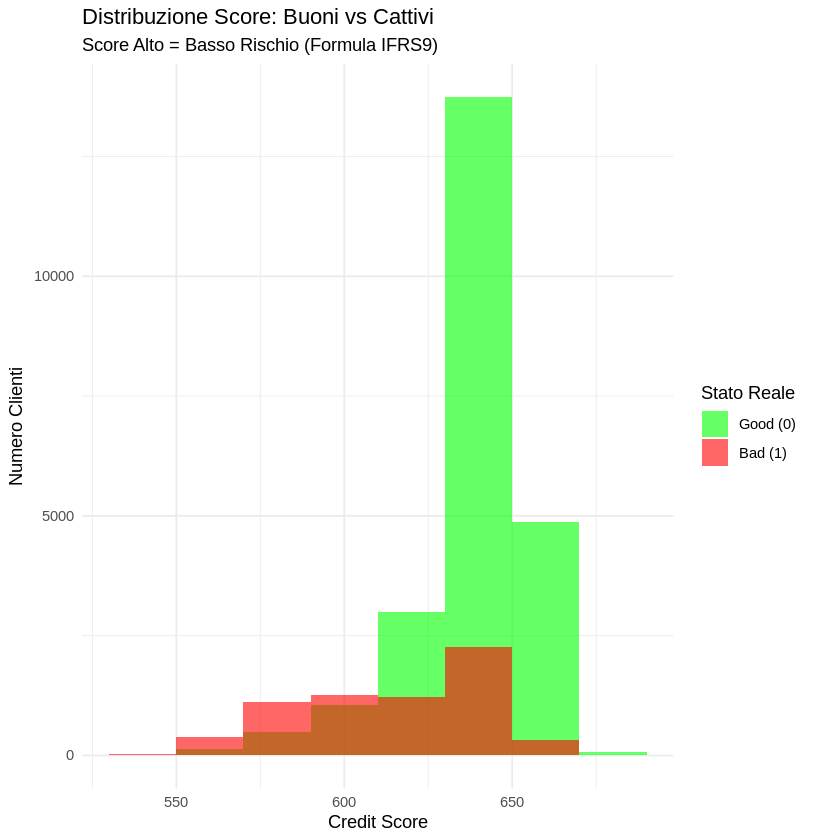

In [23]:
# --- 5. REPORT FINALE E DISTRIBUZIONE ---

print("--------------------------------------------------")
print("SCORECARD FINALE GENERATA")
print("--------------------------------------------------")
print(head(df_model[, c("target", "Estimated_PD", "Score")], 15))

# Statistiche descrittive dello Score
print("Statistiche Score:")
print(summary(df_model$Score))

# Visualizzazione Distribuzione Score (Istogramma)
if(require(ggplot2)) {
  p <- ggplot(df_model, aes(x = Score, fill = factor(target))) +
    geom_histogram(binwidth = 20, alpha = 0.6, position = "identity") +
    scale_fill_manual(values = c("green", "red"), labels = c("Good (0)", "Bad (1)")) +
    labs(
      title = "Distribuzione Score: Buoni vs Cattivi",
      subtitle = "Score Alto = Basso Rischio (Formula IFRS9)",
      x = "Credit Score",
      y = "Numero Clienti",
      fill = "Stato Reale"
    ) +
    theme_minimal()
  print(p)
}

In [24]:
#ORA TOGLIAMO LE VARIABILI CHE NON SONO SIGNIFICATIVE O CHE NON HANNO SEGNO COERENTE
# --- REFIT DEL MODELLO (PULIZIA VARIABILI) ---

# 1. Selezioniamo manualmente le variabili solide
# Escludiamo le BILL_AMT ridondanti e quelle con p-value alto
# Teniamo BILL_AMT1 per vedere se "guarisce" da sola, altrimenti la togliamo dopo.
vars_to_keep <- c(
  "LIMIT_BAL_WOE",
  "SEX_WOE",
  "EDUCATION_WOE",
  "MARRIAGE_WOE",
  "AGE_WOE",
  "PAY_0_WOE",    # La più forte
  "PAY_3_WOE",
  "PAY_4_WOE",
  "PAY_5_WOE",
  "PAY_6_WOE",
  "PAY_AMT1_WOE",
  "PAY_AMT2_WOE",
  "PAY_AMT3_WOE",
  "PAY_AMT4_WOE"
  # Ho rimosso PAY_2 (p-value alto), tutte le BILL_AMT tranne forse la 1, e PAY_AMT 5/6
)

print(paste("Rilancio il modello con", length(vars_to_keep), "variabili selezionate..."))

# 2. Creiamo la formula dinamica
final_formula_clean <- as.formula(paste("target ~", paste(vars_to_keep, collapse = " + ")))

# 3. Stima del nuovo modello
clean_model <- glm(final_formula_clean, data = df_model, family = "binomial")

# 4. Analisi dei nuovi coefficienti
summary_clean <- summary(clean_model)$coefficients

results_clean <- data.frame(
  Variable = rownames(summary_clean),
  Estimate = round(summary_clean[, "Estimate"], 4),
  P_Value = round(summary_clean[, "Pr(>|z|)"], 4)
)

print("--- RISULTATI MODELLO PULITO (REFIT) ---")
print(results_clean)

# Controllo Segni: Devono essere TUTTI NEGATIVI (tranne Intercept)
check_signs <- all(results_clean$Estimate[-1] < 0) # -1 esclude l'intercetta
print(paste("Tutti i coefficienti sono negativi?", check_signs))

# 5. Performance del modello pulito
probs_clean <- predict(clean_model, type = "response")
auc_clean <- pROC::auc(pROC::roc(df_model$target, probs_clean))
print(paste("Nuovo Gini:", round(2 * auc_clean - 1, 4)))

[1] "Rilancio il modello con 14 variabili selezionate..."
[1] "--- RISULTATI MODELLO PULITO (REFIT) ---"
                   Variable Estimate P_Value
(Intercept)     (Intercept)  -1.2493  0.0000
LIMIT_BAL_WOE LIMIT_BAL_WOE  -0.3026  0.0000
SEX_WOE             SEX_WOE  -0.7416  0.0000
EDUCATION_WOE EDUCATION_WOE  -0.3379  0.0001
MARRIAGE_WOE   MARRIAGE_WOE  -1.0673  0.0000
AGE_WOE             AGE_WOE  -0.3389  0.0020
PAY_0_WOE         PAY_0_WOE  -0.7558  0.0000
PAY_3_WOE         PAY_3_WOE  -0.2030  0.0000
PAY_4_WOE         PAY_4_WOE  -0.0973  0.0286
PAY_5_WOE         PAY_5_WOE  -0.1337  0.0036
PAY_6_WOE         PAY_6_WOE  -0.2554  0.0000
PAY_AMT1_WOE   PAY_AMT1_WOE  -0.2722  0.0000
PAY_AMT2_WOE   PAY_AMT2_WOE  -0.2348  0.0000
PAY_AMT3_WOE   PAY_AMT3_WOE  -0.2359  0.0001
PAY_AMT4_WOE   PAY_AMT4_WOE  -0.2176  0.0008
[1] "Tutti i coefficienti sono negativi? TRUE"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Nuovo Gini: 0.539"


In [25]:
# --- AGGIORNAMENTO SCORE CON MODELLO PULITO ---

# 1. Calcolo nuova PD con il modello pulito
# Assumiamo che 'clean_model' sia il tuo modello ottimizzato
df_model$Estimated_PD_Clean <- predict(clean_model, newdata = df_model, type = "response")

# 2. Ricalcolo Score (solita formula IFRS9)
# Parametri: Target 660, Odds 15, PDO 15
target_score <- 660
pdo <- 15
odds_at_target <- 15
factor <- pdo / log(2)

log_odds <- log(df_model$Estimated_PD_Clean / (1 - df_model$Estimated_PD_Clean))
df_model$Final_Score <- round(660 - factor * (log(odds_at_target) + log_odds))

# 3. Confronto e Distribuzione
print("Esempio Score Finali:")
print(head(df_model[, c("target", "Final_Score")], 10))

print("Statistiche Finali:")
print(summary(df_model$Final_Score))

# (Opzionale) Salva il risultato finale in CSV
# write.csv(df_model, "Taiwan_Model_Scored.csv", row.names = FALSE)

[1] "Esempio Score Finali:"
   target Final_Score
1       1         582
2       1         631
3       0         643
4       0         639
5       0         645
6       0         640
7       0         668
8       0         638
9       0         632
10      0         629
[1] "Statistiche Finali:"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  545.0   627.0   639.0   633.2   648.0   676.0 


In [26]:
###########################################################################

#Rating model calibration

library(dplyr)
library(ggplot2)

# --- 1. DEFINIZIONE CUT-OFFS (TAGLI) ---
# Usiamo i quantili per dividere la popolazione in 5 gruppi di dimensione circa uguale (20% l'uno)
# Questo garantisce automaticamente il rispetto della regola "tra 10% e 35%".

# Nota: Lo Score alto è "Buono". Quindi ordiniamo al contrario per avere Grade 1 = Migliore.
# Grade 1: Top 20% scores
# Grade 5: Bottom 20% scores

scores <- df_model$Score
# Calcoliamo i punti di taglio (Breakpoints)
breaks <- quantile(scores, probs = seq(0, 1, 0.2)) # 0%, 20%, 40%, 60%, 80%, 100%

# Aggiustiamo leggermente -Inf e +Inf per non perdere nessuno
breaks[1] <- -Inf
breaks[length(breaks)] <- Inf

# Assegniamo il Rating
# Usiamo 'cut'. Poiché vogliamo che Grade 1 sia il punteggio ALTO, dobbiamo invertire le etichette
# I breaks vanno dal basso all'alto.
# intervallo 1 (basso) -> Grade 5
# intervallo 5 (alto) -> Grade 1
labels_grade <- c("Grade 5", "Grade 4", "Grade 3", "Grade 2", "Grade 1")

df_model$Rating <- cut(df_model$Score, breaks = breaks, labels = labels_grade, include.lowest = TRUE)

# --- 2. CALCOLO MASTER SCALE (Statistiche per Grado) ---

master_scale <- df_model %>%
  group_by(Rating) %>%
  summarise(
    Min_Score = min(Score),
    Max_Score = max(Score),
    Count = n(),
    # Observed Default Rate (DR)
    Observed_DR = mean(target),
    # Average Model PD (Calibration PD)
    Avg_Model_PD = mean(Estimated_PD)
  ) %>%
  arrange(Rating) # Grade 1 in alto

# Calcoliamo le metriche totali per le percentuali
total_obs <- sum(master_scale$Count)

master_scale <- master_scale %>%
  mutate(
    # 1. Concentrazione (% osservazioni)
    Share_Pct = round(Count / total_obs * 100, 1),

    # 2. Incremento di Rischio (% increase vs previous grade)
    # Per Grade 1 è NA. Per Grade 2 è (DR_G2 - DR_G1) / DR_G1
    # Usiamo lag() per prendere la riga precedente (Grade migliore)
    Risk_Increase_Pct = round((Observed_DR - lag(Observed_DR)) / lag(Observed_DR) * 100, 1)
  )

# Formattiamo per la visualizzazione
master_scale_display <- master_scale %>%
  mutate(
    Observed_DR_Pct = paste0(round(Observed_DR * 100, 2), "%"),
    Avg_Model_PD_Pct = paste0(round(Avg_Model_PD * 100, 2), "%"),
    Risk_Increase = ifelse(is.na(Risk_Increase_Pct), "-", paste0("+", Risk_Increase_Pct, "%"))
  ) %>%
  select(Rating, Min_Score, Max_Score, Count, Share_Pct, Observed_DR_Pct, Avg_Model_PD_Pct, Risk_Increase)

# --- 3. OUTPUT E VERIFICA REGOLE ---

print("----------------------------------------------------------")
print("MASTER SCALE (CALIBRAZIONE)")
print("----------------------------------------------------------")
print(master_scale_display)

# VERIFICA REGOLE DEL PDF
print("--- VERIFICA CRITERI IFRS9 ---")

# Regola 1: Concentrazione (10% - 35%)
check_conc <- all(master_scale$Share_Pct >= 10 & master_scale$Share_Pct <= 35)
print(paste("1. Concentrazione (10-35%):", ifelse(check_conc, "OK", "FAIL (Verifica i bin)")))

# Regola 2: Monotonicità (DR Crescente)
# Verifichiamo se DR di Grade 2 > Grade 1, ecc.
# Nota: Poiché abbiamo ordinato Grade 1 (basso DR) -> Grade 5 (alto DR), l'Observed_DR deve CRESCERE
drs <- master_scale$Observed_DR
check_mono <- all(diff(drs) > 0)
print(paste("2. Monotonicità DR:", ifelse(check_mono, "OK", "FAIL (Zig-Zag nei rating)")))

# Regola 3: Distinzione Rischio (+50% tra classi)
# Controlliamo se Risk_Increase è > 50% per le classi da 2 a 5
risk_jumps <- master_scale$Risk_Increase_Pct[-1] # Escludi Grade 1
check_jumps <- all(risk_jumps >= 50)
print(paste("3. Salto di Rischio (>50%):", ifelse(check_jumps, "OK", paste("FAIL - Salti attuali:", paste(risk_jumps, collapse=", ")))))

[1] "----------------------------------------------------------"
[1] "MASTER SCALE (CALIBRAZIONE)"
[1] "----------------------------------------------------------"
# A tibble: 5 × 8
  Rating  Min_Score Max_Score Count Share_Pct Observed_DR_Pct Avg_Model_PD_Pct
  <fct>       <dbl>     <dbl> <int>     <dbl> <chr>           <chr>           
1 Grade 5       545       619  6088      20.3 55.57%          55.3%           
2 Grade 4       620       636  6055      20.2 22.15%          20.97%          
3 Grade 3       637       643  6683      22.3 14.57%          14.39%          
4 Grade 2       644       650  5896      19.7 10.46%          10.93%          
5 Grade 1       651       679  5278      17.6 6.08%           7.45%           
# ℹ 1 more variable: Risk_Increase <chr>
[1] "--- VERIFICA CRITERI IFRS9 ---"
[1] "1. Concentrazione (10-35%): OK"
[1] "2. Monotonicità DR: FAIL (Zig-Zag nei rating)"
[1] "3. Salto di Rischio (>50%): FAIL - Salti attuali: -60.1, -34.2, -28.2, -41.9"


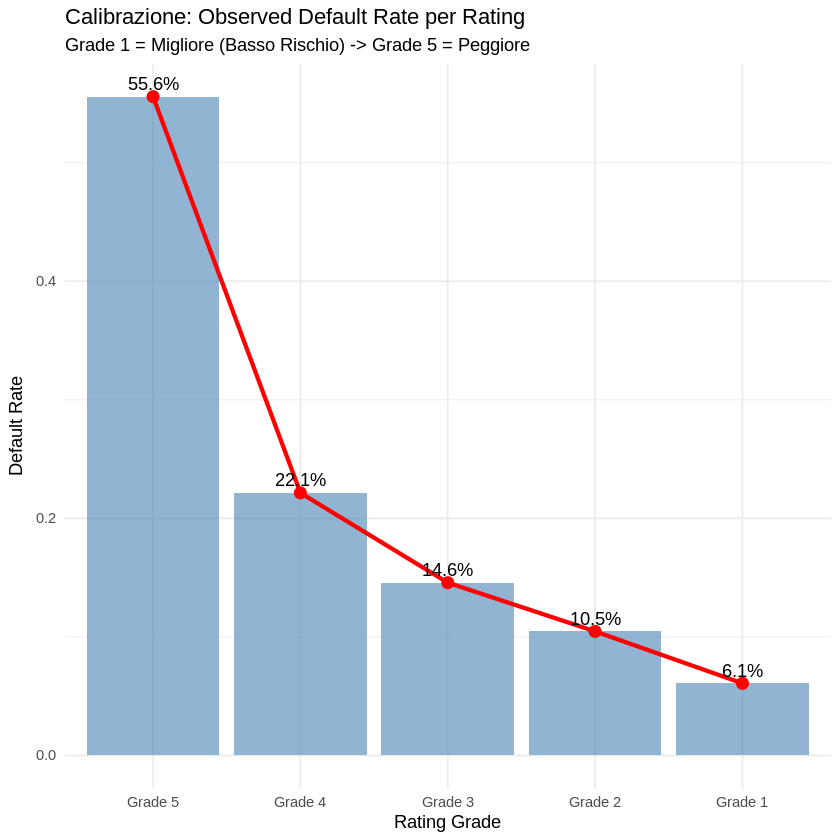

In [27]:
# --- 4. VISUALIZZAZIONE GRAFICA ---
# Plot della Master Scale (Relazione Score vs DR)

ggplot(master_scale, aes(x = Rating, y = Observed_DR, group = 1)) +
  geom_bar(stat = "identity", fill = "steelblue", alpha = 0.6) +
  geom_line(color = "red", size = 1.2) +
  geom_point(color = "red", size = 3) +
  geom_text(aes(label = paste0(round(Observed_DR*100, 1), "%")), vjust = -0.5) +
  labs(
    title = "Calibrazione: Observed Default Rate per Rating",
    subtitle = "Grade 1 = Migliore (Basso Rischio) -> Grade 5 = Peggiore",
    y = "Default Rate",
    x = "Rating Grade"
  ) +
  theme_minimal()